In [2]:
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

import math

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img

%load_ext autoreload
%autoreload 2

import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2, CNNMnist3
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img
from torch.utils.data import DataLoader, Dataset
from utils.functions import *

%load_ext autoreload
%autoreload 2

class DatasetSplit(Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = list(idxs)

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, label



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. G=2, N=4 (N_1=2, N_2=2), K=4 (K_1=2, K_2=2)

In [28]:
class my_argument:    
    epochs = 200    #"rounds of training"
    num_users = 15  # "number of users: N"
    num_partition = 4 # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep = 1 #"the number of local epochs: E"
    local_bs = 200 #"local batch size: B"
    bs=200 #"test batch size"
    lr=0.01 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Custom' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='None' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='mnist' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

# load dataset and split users
trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)

dict_users = mnist_iid(dataset_train, args.num_partition)

encoding_input_array_np = np.empty((len(dataset_train),28*28))
encoding_label_array_np = np.empty((len(dataset_train),args.num_classes))
print("size of X:" ,encoding_input_array_np.shape)
print("size of Y:" ,encoding_label_array_np.shape)

Size_submatrices = int(60000/args.num_partition)

for i in range(args.num_partition):
    
    stt_pos = i*Size_submatrices
    end_pos = (i+1)*Size_submatrices
#     print(i,stt_pos,end_pos)
    Temp_train = DataLoader(DatasetSplit(dataset_train, dict_users[i]), batch_size=Size_submatrices, shuffle=True)
    
    for batch_idx, (images, labels) in enumerate(Temp_train):
        
        images_np = images.detach().cpu().numpy()
        encoding_input_array_np[stt_pos:end_pos,:] = np.reshape(images_np, (Size_submatrices,28*28))
#         print(encoding_input_array_np[stt_pos:end_pos,:].shape)

        onehot_labels = torch.nn.functional.one_hot(labels,num_classes=args.num_classes)
        labels_np = onehot_labels.detach().cpu().numpy()
#         print(labels_np.shape)
        encoding_label_array_np[stt_pos:end_pos,:] = labels_np


# print(labels_np[0:10,:])

size of X: (60000, 784)
size of Y: (60000, 10)


In [29]:
G = 2
N = 4 # N should be divisible by G
K = 4 # N should be divisible by G

size_per_group = int(60000/G)

X_group = np.reshape(encoding_input_array_np, (G,size_per_group,28*28))
y_group = np.reshape(encoding_label_array_np, (G,size_per_group,args.num_classes)) 

In [30]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

N_i = int(N/G) # = 2
K_i = int(K/G) # = 2
T = 3
sigma = 1
Noise_Alloc = [0,2,4]
m = N_i # number of selected workers (if there is no straggler, m=N_i)

print(N_i,K_i,T)

Signal_Alloc = []
for i in range(K_i+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K_i+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K_i+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

z_array = np.array([-0.81, 0.81])

B = 0.5

N_trials = 1
N_epochs = 30

loss_test_arr_G2 = np.zeros((N_trials,N_epochs))
acc_test_arr_G2  = np.zeros((N_trials,N_epochs))

for trial_idx in range(N_trials):
    
    print('##########################################')
    print('######',trial_idx,'-th Trial!! ###########')
    
    net_glob = CNNMnist2(args=args)
    net_glob.cuda()
    net_glob.train()
    
    # copy weights
    w_glob = net_glob.state_dict()
    
    X_tilde = np.empty((N,Size_submatrices,28*28))
    y_tilde = np.empty((N,Size_submatrices,10))
    
    for G_idx in range(G):
        
        _Noise_label = np.ones((size_per_group*T,10)) * 0.1
        
        X_tilde_tmp,a,b = BACC_Enc_Data_v3(X_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde_tmp,a,b = BACC_Enc_Data_v3(y_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)
        
        stt_pos = G_idx * N_i
        end_pos = (G_idx+1) * N_i
        
        X_tilde[stt_pos:end_pos,:,:] = X_tilde_tmp
        y_tilde[stt_pos:end_pos,:,:] = y_tilde_tmp
        
   

    for iter in range(N_epochs): #args.epochs
        
        w_group_array = []
        for G_idx in range(G):
            w_locals, loss_locals = [], []
            idxs_users = np.random.choice(range(N_i), m, replace=False)
            idxs_users = np.sort(idxs_users)
            print('selected users:',idxs_users)

            coded_net = BACC_Enc_Model_withNoise_v3(net_glob.cuda(), N_i, K_i, T, 0.01, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

            dec_z_array = []
            for idx in idxs_users: #for idx in range(N):
        #         print(idx)
                local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[G_idx*N_i+idx,:,:], label=y_tilde[G_idx*N_i+idx,:,:])
                w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
#                 w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))

                dec_z_array.append(z_array[idx])


            # update global weights
            #w_glob = FedAvg(w_locals)
            w_group = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)
            
            w_group_array.append(copy.deepcopy(w_group))
        
        w_glob = copy.deepcopy(w_group_array[0])
        for k in w_glob.keys():
            for G_idx in range(1,G):
                w_glob[k] += w_group_array[G_idx][k]
            w_glob[k] = torch.div(w_glob[k], len(w_group_array))
        
        # copy weight to net_glob
        net_glob.load_state_dict(w_glob)

        # print loss
    #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

    #     loss_train_arr.append(loss_train)

        acc_test, loss_test = test_img(net_glob, dataset_test, args)
        acc_test_arr_G2[trial_idx][iter] = acc_test
        loss_test_arr_G2[trial_idx][iter] = loss_test

        
        
    

2 2 3
##########################################
###### 0 -th Trial!! ###########
@BACC_Enc: N,K,T, m_i= 2 2 3 15000 

@BACC_Enc: N,K,T, m_i= 2 2 3 15000 

@BACC_Enc: N,K,T, m_i= 2 2 3 15000 

@BACC_Enc: N,K,T, m_i= 2 2 3 15000 

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 2.2973 
Accuracy: 2163/10000 (21.63%)

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 2.2949 
Accuracy: 1899/10000 (18.99%)

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 1.8496 
Accuracy: 7254/10000 (72.54%)

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 0.3448 
Accuracy: 9530/10000 (95.30%)

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 0.3019 
Accuracy: 9539/10000 (95.39%)

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 0.2349 
Accuracy: 9617/10000 (96.17%)

selected users: 

In [13]:
print(np.shape(X_group[G_idx,:,:]))

(30000, 784)


# 2. G=3, K=6 (K_i=2), N=6 (N_i=6)

In [21]:
class my_argument:    
    epochs = 200    #"rounds of training"
    num_users = 15  # "number of users: N"
    num_partition = 6 # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep = 1 #"the number of local epochs: E"
    local_bs = 200 #"local batch size: B"
    bs=200 #"test batch size"
    lr=0.01 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Custom' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='None' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='mnist' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

# load dataset and split users
trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)

dict_users = mnist_iid(dataset_train, args.num_partition)

encoding_input_array_np = np.empty((len(dataset_train),28*28))
encoding_label_array_np = np.empty((len(dataset_train),args.num_classes))
print("size of X:" ,encoding_input_array_np.shape)
print("size of Y:" ,encoding_label_array_np.shape)

Size_submatrices = int(60000/args.num_partition)

for i in range(args.num_partition):
    
    stt_pos = i*Size_submatrices
    end_pos = (i+1)*Size_submatrices
#     print(i,stt_pos,end_pos)
    Temp_train = DataLoader(DatasetSplit(dataset_train, dict_users[i]), batch_size=Size_submatrices, shuffle=True)
    
    for batch_idx, (images, labels) in enumerate(Temp_train):
        
        images_np = images.detach().cpu().numpy()
        encoding_input_array_np[stt_pos:end_pos,:] = np.reshape(images_np, (Size_submatrices,28*28))
#         print(encoding_input_array_np[stt_pos:end_pos,:].shape)

        onehot_labels = torch.nn.functional.one_hot(labels,num_classes=args.num_classes)
        labels_np = onehot_labels.detach().cpu().numpy()
#         print(labels_np.shape)
        encoding_label_array_np[stt_pos:end_pos,:] = labels_np


# print(labels_np[0:10,:])

size of X: (60000, 784)
size of Y: (60000, 10)


In [22]:
G = 3
N = 6 # N should be divisible by G
K = 6 # N should be divisible by G

size_per_group = int(60000/G)

X_group = np.reshape(encoding_input_array_np, (G,size_per_group,28*28))
y_group = np.reshape(encoding_label_array_np, (G,size_per_group,args.num_classes)) 

In [24]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

N_i = int(N/G)
K_i = int(K/G)
T = 3
sigma = 1
Noise_Alloc = [0,2,4]
m = N_i # number of selected workers (if there is no straggler, m=N_i)

print(N_i,K_i,T)

Signal_Alloc = []
for i in range(K_i+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K_i+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K_i+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

z_array = np.array([-0.81, 0.81])

B = 0.5

N_trials = 1
N_epochs = 30

loss_test_arr_G3 = np.zeros((N_trials,N_epochs))
acc_test_arr_G3  = np.zeros((N_trials,N_epochs))

for trial_idx in range(N_trials):
    
    print('##########################################')
    print('######',trial_idx,'-th Trial!! ###########')
    
    net_glob = CNNMnist2(args=args)
    net_glob.cuda()
    net_glob.train()
    
    # copy weights
    w_glob = net_glob.state_dict()
    
    X_tilde = np.empty((N,Size_submatrices,28*28))
    y_tilde = np.empty((N,Size_submatrices,10))
    
    for G_idx in range(G):
        
        _Noise_label = np.ones((size_per_group*T,10)) * 0.1
        
        X_tilde_tmp,a,b = BACC_Enc_Data_v3(X_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde_tmp,a,b = BACC_Enc_Data_v3(y_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)
        
        stt_pos = G_idx * N_i
        end_pos = (G_idx+1) * N_i
        
        X_tilde[stt_pos:end_pos,:,:] = X_tilde_tmp
        y_tilde[stt_pos:end_pos,:,:] = y_tilde_tmp
        
   

    for iter in range(N_epochs): #args.epochs
        
        w_group_array = []
        for G_idx in range(G):
            w_locals, loss_locals = [], []
            idxs_users = np.random.choice(range(N_i), m, replace=False)
            idxs_users = np.sort(idxs_users)
            print('selected users:',idxs_users)

            coded_net = BACC_Enc_Model_withNoise_v3(net_glob.cuda(), N_i, K_i, T, 0.01, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

            dec_z_array = []
            for idx in idxs_users: #for idx in range(N):
        #         print(idx)
                local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[G_idx*N_i+idx,:,:], label=y_tilde[G_idx*N_i+idx,:,:])
                w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))

                dec_z_array.append(z_array[idx])


            # update global weights
            #w_glob = FedAvg(w_locals)
            w_group = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)
            
            w_group_array.append(copy.deepcopy(w_group))
        
        w_glob = copy.deepcopy(w_group_array[0])
        for k in w_glob.keys():
            for G_idx in range(1,G):
                w_glob[k] += w_group_array[G_idx][k]
            w_glob[k] = torch.div(w_glob[k], len(w_group_array))
        
        # copy weight to net_glob
        net_glob.load_state_dict(w_glob)

        # print loss
    #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

    #     loss_train_arr.append(loss_train)

        acc_test, loss_test = test_img(net_glob, dataset_test, args)
        acc_test_arr_G3[trial_idx][iter] = acc_test
        loss_test_arr_G3[trial_idx][iter] = loss_test

        
        
    

2 2 3
##########################################
###### 0 -th Trial!! ###########
@BACC_Enc: N,K,T, m_i= 2 2 3 10000 

@BACC_Enc: N,K,T, m_i= 2 2 3 10000 

@BACC_Enc: N,K,T, m_i= 2 2 3 10000 

@BACC_Enc: N,K,T, m_i= 2 2 3 10000 

@BACC_Enc: N,K,T, m_i= 2 2 3 10000 

@BACC_Enc: N,K,T, m_i= 2 2 3 10000 

selected users: [0 1]
selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 2.3026 
Accuracy: 1027/10000 (10.27%)

selected users: [0 1]
selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 2.2964 
Accuracy: 2574/10000 (25.74%)

selected users: [0 1]
selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 2.2028 
Accuracy: 5098/10000 (50.98%)

selected users: [0 1]
selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 1.4135 
Accuracy: 6138/10000 (61.38%)

selected users: [0 1]
selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 0.8341 
Accuracy: 8016/10000 (80.16%)

selected users: [0 1]
selected users: [0 1]
se

# 3. K=2, Without Grouping

In [19]:
class my_argument:    
    epochs = 200    #"rounds of training"
    num_users = 15  # "number of users: N"
    num_partition = 2 # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep = 1 #"the number of local epochs: E"
    local_bs = 200 #"local batch size: B"
    bs=200 #"test batch size"
    lr=0.01 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Custom' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='None' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='mnist' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

# load dataset and split users
trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)

dict_users = mnist_iid(dataset_train, args.num_partition)

encoding_input_array_np = np.empty((len(dataset_train),28*28))
encoding_label_array_np = np.empty((len(dataset_train),args.num_classes))
print("size of X:" ,encoding_input_array_np.shape)
print("size of Y:" ,encoding_label_array_np.shape)

Size_submatrices = int(60000/args.num_partition)

for i in range(args.num_partition):
    
    stt_pos = i*Size_submatrices
    end_pos = (i+1)*Size_submatrices
#     print(i,stt_pos,end_pos)
    Temp_train = DataLoader(DatasetSplit(dataset_train, dict_users[i]), batch_size=Size_submatrices, shuffle=True)
    
    for batch_idx, (images, labels) in enumerate(Temp_train):
        
        images_np = images.detach().cpu().numpy()
        encoding_input_array_np[stt_pos:end_pos,:] = np.reshape(images_np, (Size_submatrices,28*28))
#         print(encoding_input_array_np[stt_pos:end_pos,:].shape)

        onehot_labels = torch.nn.functional.one_hot(labels,num_classes=args.num_classes)
        labels_np = onehot_labels.detach().cpu().numpy()
#         print(labels_np.shape)
        encoding_label_array_np[stt_pos:end_pos,:] = labels_np


# print(labels_np[0:10,:])

size of X: (60000, 784)
size of Y: (60000, 10)


In [20]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

K = 2
T = 3
sigma = 1
Noise_Alloc = [0,2,4]

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [2,4,6,8]
B_array = [0.5]

N_trials = 1
N_epochs = 30



loss_test_arr_v1 = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))
acc_test_arr_v1  = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))

for N_idx in range(len(N_array)):
    
    N = N_array[N_idx]
    
    
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for B_idx in range(len(B_array)):
        
        B = B_array[B_idx]
        z_array = []
#         while(len(z_array)<N):
#             z_tmp = np.random.uniform(-1,1,1)
#             MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
#             if MIS_tmp < B and MIS_tmp > 0.1:
#                 z_array.append(z_tmp[0])
#         
#         z_array = np.sort(z_array)

        if N==2:
            z_array = np.array([-0.81, 0.81])
        elif N ==4:
            z_array = np.array([-0.81, -0.22, 0.22, 0.81])
        elif N ==5:
            z_array = np.array([-0.81, -0.22, 0, 0.22, 0.81])
        elif N ==6:
            z_array = np.array([-0.9, -0.81, -0.22, 0.22, 0.81, 0.9])
        elif N ==7:
            z_array = np.array([-0.9, -0.82, -0.21, 0, 0.21, 0.82, 0.9])
        else:
            z_array = np.array([-0.9, -0.81, -0.22, -0.16, 0.16, 0.22, 0.81, 0.9])
#             z_array = np.array([-0.9, -0.81, -0.22, -0.20, 0.20, 0.22, 0.81, 0.9])
            
        print('z_array:',z_array)
        for j in range(len(z_array)):
            print(MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma))
        
        
        _Noise_label = np.ones((30000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNMnist2(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
                coded_net = BACC_Enc_Model_withNoise_v3(net_glob.cuda(), N, K, T, 0.01, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                    w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_v1[N_idx][B_idx][trial_idx][iter] = acc_test
                loss_test_arr_v1[N_idx][B_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

z_array: [-0.81  0.81]
0.4838626198316927
0.48386261983169315
@BACC_Enc: N,K,T, m_i= 2 2 3 30000 

@BACC_Enc: N,K,T, m_i= 2 2 3 30000 

(T, sigma)= 3 1 )  0 -th Trial!!
selected users: [0 1]

Test set: Average loss: 2.1504 
Accuracy: 5550/10000 (55.50%)

Round   0, Average loss 2.150 Test accuracy 55.500
selected users: [0 1]

Test set: Average loss: 0.7712 
Accuracy: 8177/10000 (81.77%)

Round   1, Average loss 0.771 Test accuracy 81.770
selected users: [0 1]

Test set: Average loss: 0.2180 
Accuracy: 9692/10000 (96.92%)

Round   2, Average loss 0.218 Test accuracy 96.920
selected users: [0 1]

Test set: Average loss: 0.1758 
Accuracy: 9740/10000 (97.40%)

Round   3, Average loss 0.176 Test accuracy 97.400
selected users: [0 1]

Test set: Average loss: 0.1905 
Accuracy: 9728/10000 (97.28%)

Round   4, Average loss 0.191 Test accuracy 97.280
selected users: [0 1]

Test set: Average loss: 0.1868 
Accuracy: 9750/10000 (97.50%)

Round   5, Average loss 0.187 Test accuracy 97.500
selected 


Test set: Average loss: 1.9353 
Accuracy: 9652/10000 (96.52%)

Round  27, Average loss 1.935 Test accuracy 96.520
selected users: [0 1 2 3]

Test set: Average loss: 1.7971 
Accuracy: 9755/10000 (97.55%)

Round  28, Average loss 1.797 Test accuracy 97.550
selected users: [0 1 2 3]

Test set: Average loss: 1.9200 
Accuracy: 9682/10000 (96.82%)

Round  29, Average loss 1.920 Test accuracy 96.820
z_array: [-0.9  -0.81 -0.22  0.22  0.81  0.9 ]
0.039572349708934106
0.4838626198316927
0.46852880899669475
0.468528808996694
0.48386261983169315
0.039572349708934106
@BACC_Enc: N,K,T, m_i= 6 2 3 30000 

@BACC_Enc: N,K,T, m_i= 6 2 3 30000 

(T, sigma)= 3 1 )  0 -th Trial!!
selected users: [0 1 2 3 4 5]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [0 1 2 3 4 5]

Test set: Average loss: 2.2223 
Accuracy: 6257/10000 (62.57%)

Round   1, Average loss 2.222 Test accuracy 62.570
selected users: [0 1 2 3 4 5]

Test set: Av


Test set: Average loss: 0.5977 
Accuracy: 9224/10000 (92.24%)

Round  19, Average loss 0.598 Test accuracy 92.240
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 0.3295 
Accuracy: 9644/10000 (96.44%)

Round  20, Average loss 0.330 Test accuracy 96.440
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 0.3735 
Accuracy: 9571/10000 (95.71%)

Round  21, Average loss 0.373 Test accuracy 95.710
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 0.3915 
Accuracy: 9354/10000 (93.54%)

Round  22, Average loss 0.391 Test accuracy 93.540
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 0.4134 
Accuracy: 9209/10000 (92.09%)

Round  23, Average loss 0.413 Test accuracy 92.090
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 0.4039 
Accuracy: 9634/10000 (96.34%)

Round  24, Average loss 0.404 Test accuracy 96.340
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 0.4398 
Accuracy: 9725/10000 (97.25%)

Round  25, Average loss 0.440 Test accurac

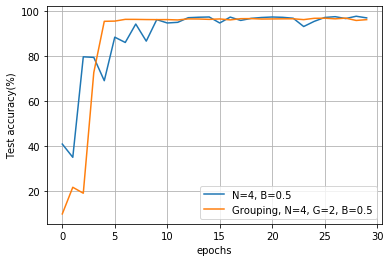

In [35]:
B_sel = 0

# plt.plot(acc_test_arr_v1[0,B_sel,0,0:30],label='N=2, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_v1[1,B_sel,0,0:30],label='N=4, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v1[2,B_sel,0,0:30],label='N=6, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v1[3,B_sel,0,0:30],label='N=8, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_G2[0,0:30],label='Grouping, N=4, G=2, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_G3[0,0:30],label='Grouping, N=6, G=3, B='+str(B_array[B_sel]))

# plt.plot(acc_test_arr_v1[4,B_sel,0,0:30],label='N=7, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v1[5,B_sel,0,0:30],label='N=8, B='+str(B_array[B_sel]))

# plt.plot(plot_acc_v2[2,sigma_sel,:],label='T=10')
# plt.plot(plot_acc_v2[3,sigma_sel,:],label='T=11')

# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

# 4. K=4

In [10]:
class my_argument:    
    epochs = 200    #"rounds of training"
    num_users = 15  # "number of users: N"
    num_partition = 4 # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep = 1 #"the number of local epochs: E"
    local_bs = 200 #"local batch size: B"
    bs=200 #"test batch size"
    lr=0.01 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Custom' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='None' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='mnist' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

# load dataset and split users
trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)

dict_users = mnist_iid(dataset_train, args.num_partition)

encoding_input_array_np = np.empty((len(dataset_train),28*28))
encoding_label_array_np = np.empty((len(dataset_train),args.num_classes))
print("size of X:" ,encoding_input_array_np.shape)
print("size of Y:" ,encoding_label_array_np.shape)

Size_submatrices = int(60000/args.num_partition)

for i in range(args.num_partition):
    
    stt_pos = i*Size_submatrices
    end_pos = (i+1)*Size_submatrices
#     print(i,stt_pos,end_pos)
    Temp_train = DataLoader(DatasetSplit(dataset_train, dict_users[i]), batch_size=Size_submatrices, shuffle=True)
    
    for batch_idx, (images, labels) in enumerate(Temp_train):
        
        images_np = images.detach().cpu().numpy()
        encoding_input_array_np[stt_pos:end_pos,:] = np.reshape(images_np, (Size_submatrices,28*28))
#         print(encoding_input_array_np[stt_pos:end_pos,:].shape)

        onehot_labels = torch.nn.functional.one_hot(labels,num_classes=args.num_classes)
        labels_np = onehot_labels.detach().cpu().numpy()
#         print(labels_np.shape)
        encoding_label_array_np[stt_pos:end_pos,:] = labels_np


# print(labels_np[0:10,:])

size of X: (60000, 784)
size of Y: (60000, 10)


395 137 77 66 325


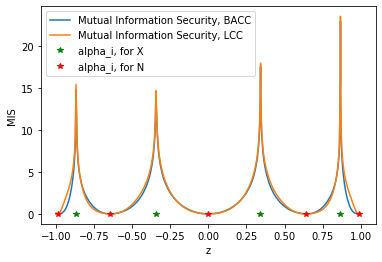

-0.9967233991100619 0.012570500902590362
-0.9948458393310273 0.009186154041335111
-0.9903708272549521 0.0030278602507773783
-0.9881497879818113 0.0011322378640799269
-0.9856357664431257 7.237229030193549e-05
-0.9819502816066774 0.0009151342222115455
-0.9743801406025652 0.013807862953069145
-0.9732429036029051 0.017308391808860374
-0.9716499425996106 0.02300816009848999
-0.9707810034884226 0.026529720146499475
-0.9629358119852338 0.07356572119174355
-0.9592848094889013 0.10648755223399524
-0.9578307990518302 0.12188755258432364
-0.9571486494917996 0.12959372414089768
-0.9548728694739659 0.15764285382604115
-0.9543836651467361 0.16416119397904505
-0.9512302584551071 0.21060896428961837
-0.9501286871582235 0.22873571263139653
-0.9493079992209263 0.24291445045342466
-0.9468712143720244 0.2885550929930391
-0.9462045027048012 0.3020009958277021
-0.9450226360856129 0.3268894006886918
-0.942889051744954 0.37535344112475444
-0.9420255449368415 0.3963084326299616
-0.9399882819365448 0.4489394665

-0.05391121245331343 0.08429198796341066
-0.05116035452277945 0.07578293577457994
-0.04994750389353486 0.07218121551212613
-0.047126382974370884 0.06415583985005885
-0.046510482267415165 0.06246897693064006
-0.045224290722228 0.059021297802406635
-0.04302562861680004 0.05336170018208458
-0.04279176091843295 0.052777010177149704
-0.042151974953842375 0.05119444792253114
-0.0419389393921108 0.05067299418835479
-0.037184159104619585 0.03974693693077096
-0.03599721971014902 0.03723101295809522
-0.034571804105439696 0.03432061510526045
-0.032943207737284874 0.03114315714139796
-0.02942909211734679 0.02482133992077939
-0.02763593275015186 0.021875507639314232
-0.0229133855453163 0.015016784374369168
-0.02193911643328339 0.013763363491504177
-0.020419263130643017 0.011917939772911697
-0.01960321250414343 0.010982258618801446
-0.018245328503861957 0.009510612438407
-0.01776810438720222 0.009018683061269081
-0.0156854533165125 0.007025478286782084
-0.013339936301562716 0.005079418947050514
-0.0

In [5]:
K = 4
T = 5
Noise_Alloc = [0,2,4,6,8]
sigma = 1

N = 10

j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T)))

i_array = np.array(range(N))
beta_array = np.cos(i_array*2*math.pi/(N-1)/2) # np.cos(i_array*2*math.pi/N/2)
# print("z_array: ",z_array,'\n')

N = 1000
z_array = np.random.uniform(-1,1,N) #np.cos(i_array[1:]*2*math.pi/(K+T)/2) # np.cos(i_array*2*math.pi/N/2)
z_array = np.sort(z_array)
MIS_array = np.zeros((N))
MIS_LCC_array = np.zeros((N))
# print(z_array)

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)

B = [0.5, 1, 1.5, 2]

z_array_0 = []
z_array_1 = []
z_array_2 = []
z_array_3 = []
z_array_4 = []

for j in range(len(z_array)):
    MIS_array[j] = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma)
    MIS_LCC_array[j] = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma, _is_LCC=True)
    
    if MIS_array[j] < B[0]:
        z_array_0.append(z_array[j])
    elif MIS_array[j] < B[1]:
        z_array_1.append(z_array[j])
    elif MIS_array[j] < B[2]:
        z_array_2.append(z_array[j])
    elif MIS_array[j] < B[3]:
        z_array_3.append(z_array[j])
    else:
        z_array_4.append(z_array[j])
#     print('(beta index, MIS) = ',j,',',MIS_array[j])
#     print()



print(len(z_array_0),len(z_array_1),len(z_array_2),len(z_array_3),len(z_array_4))


plt.plot(z_array, MIS_array, label='Mutual Information Security, BACC')
plt.plot(z_array, MIS_LCC_array, label='Mutual Information Security, LCC')
plt.plot(alpha_array[Signal_Alloc],0*np.ones(len(Signal_Alloc)),'g*',label='alpha_i, for X')
plt.plot(alpha_array[Noise_Alloc],0*np.ones(len(Noise_Alloc)),'r*',label='alpha_i, for N')
# plt.plot(beta_array,0*np.ones(len(beta_array)),'b.',label='beta_i')
plt.xlabel('z')
plt.ylabel('MIS')
plt.legend()
plt.show()
    
for i in range(len(z_array)):
    print(z_array[i],MIS_array[i])
    
# print(alpha_array[Signal_Alloc])
# print(alpha_array[Noise_Alloc])
# print(alpha_array)

# plt.plot((2*j_array[Signal_Alloc]+1)/(K+T),alpha_array[Signal_Alloc],'g*',label='alpha_i, for X')
# plt.plot((2*j_array[Noise_Alloc]+1)/(K+T),alpha_array[Noise_Alloc],'r*',label='alpha_i, for N')
# plt.plot(2*i_array[1:]/(K+T), z_array,'b.',label='beta_i')
# plt.legend()
# plt.show()

In [8]:
z_array_ = np.array([-0.94, -0.73, -0.534, -0.125, 0.125, 0.534, 0.73, 0.94])
MIS_array_ = np.zeros(len(z_array_))
for j in range(len(z_array_)):
    MIS_array_[j] = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array_[j]], 1,sigma)

print(MIS_array_)


[0.44862362 0.49983047 0.4896348  0.48571877 0.48571877 0.4896348
 0.49983047 0.44862362]


In [52]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

K = 4
T = 5
sigma = 1
Noise_Alloc = [0,2,4,6,8]

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [4, 4, 4, 8]
B_array = [0.5]

N_trials = 1
N_epochs = 30



loss_test_arr_K4_G1 = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))
acc_test_arr_K4_G1  = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))

for N_idx in range(len(N_array)):
    
    N = N_array[N_idx]
    
    
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for B_idx in range(len(B_array)):
        
        B = B_array[B_idx]
        z_array = []
#         while(len(z_array)<N):
#             z_tmp = np.random.uniform(-1,1,1)
#             MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
#             if MIS_tmp < B and MIS_tmp > 0.1:
#                 z_array.append(z_tmp[0])
#         
#         z_array = np.sort(z_array)
        print(N_idx,'!!!')
        if N_idx==0:
            z_array = np.array([-0.94,-0.534,0.534, 0.94])
        elif N_idx==1:
            z_array = np.array([-0.94, -0.73, 0.73, 0.94])
        elif N_idx==2:
            z_array = np.array([-0.94, -0.125, 0.125, 0.94])
        else:
            z_array = np.array([-0.94, -0.73, -0.534, -0.125, 0.125, 0.534, 0.73, 0.94])
#             z_array = np.array([-0.9, -0.81, -0.22, -0.20, 0.20, 0.22, 0.81, 0.9])
            
        print('z_array:',z_array)
        for j in range(len(z_array)):
            print(MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma))
        
        
        _Noise_label = np.ones((15000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNMnist2(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
                coded_net = BACC_Enc_Model_withNoise_v3(net_glob.cuda(), N, K, T, 0.01, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                    w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
#                     w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_K4_G1[N_idx][B_idx][trial_idx][iter] = acc_test
                loss_test_arr_K4_G1[N_idx][B_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

0 !!!
z_array: [-0.94  -0.534  0.534  0.94 ]
0.4486236179368535
0.48963480280841937
0.4896348028084205
0.4486236179368556
@BACC_Enc: N,K,T, m_i= 4 4 5 15000 

@BACC_Enc: N,K,T, m_i= 4 4 5 15000 

(T, sigma)= 5 1 )  0 -th Trial!!
selected users: [0 1 2 3]

Test set: Average loss: 2.1096 
Accuracy: 5721/10000 (57.21%)

Round   0, Average loss 2.110 Test accuracy 57.210
selected users: [0 1 2 3]

Test set: Average loss: 1.1266 
Accuracy: 7100/10000 (71.00%)

Round   1, Average loss 1.127 Test accuracy 71.000
selected users: [0 1 2 3]

Test set: Average loss: 0.5521 
Accuracy: 8830/10000 (88.30%)

Round   2, Average loss 0.552 Test accuracy 88.300
selected users: [0 1 2 3]

Test set: Average loss: 0.5766 
Accuracy: 8792/10000 (87.92%)

Round   3, Average loss 0.577 Test accuracy 87.920
selected users: [0 1 2 3]

Test set: Average loss: 0.5347 
Accuracy: 8754/10000 (87.54%)

Round   4, Average loss 0.535 Test accuracy 87.540
selected users: [0 1 2 3]

Test set: Average loss: 0.4962 
Accurac


Test set: Average loss: 1.9437 
Accuracy: 4549/10000 (45.49%)

Round  25, Average loss 1.944 Test accuracy 45.490
selected users: [0 1 2 3]

Test set: Average loss: 1.9621 
Accuracy: 4538/10000 (45.38%)

Round  26, Average loss 1.962 Test accuracy 45.380
selected users: [0 1 2 3]

Test set: Average loss: 1.5629 
Accuracy: 5165/10000 (51.65%)

Round  27, Average loss 1.563 Test accuracy 51.650
selected users: [0 1 2 3]

Test set: Average loss: 1.5378 
Accuracy: 4532/10000 (45.32%)

Round  28, Average loss 1.538 Test accuracy 45.320
selected users: [0 1 2 3]

Test set: Average loss: 1.7706 
Accuracy: 3791/10000 (37.91%)

Round  29, Average loss 1.771 Test accuracy 37.910
2 !!!
z_array: [-0.94  -0.125  0.125  0.94 ]
0.4486236179368535
0.4857187736123886
0.48571877361238697
0.4486236179368556
@BACC_Enc: N,K,T, m_i= 4 4 5 15000 

@BACC_Enc: N,K,T, m_i= 4 4 5 15000 

(T, sigma)= 5 1 )  0 -th Trial!!
selected users: [0 1 2 3]

Test set: Average loss: 2.3026 
Accuracy: 1009/10000 (10.09%)

Ro


Test set: Average loss: 1.8736 
Accuracy: 9199/10000 (91.99%)

Round  19, Average loss 1.874 Test accuracy 91.990
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 1.9324 
Accuracy: 9358/10000 (93.58%)

Round  20, Average loss 1.932 Test accuracy 93.580
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 1.8969 
Accuracy: 9094/10000 (90.94%)

Round  21, Average loss 1.897 Test accuracy 90.940
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 1.8659 
Accuracy: 9164/10000 (91.64%)

Round  22, Average loss 1.866 Test accuracy 91.640
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 1.8866 
Accuracy: 8781/10000 (87.81%)

Round  23, Average loss 1.887 Test accuracy 87.810
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 1.8758 
Accuracy: 9261/10000 (92.61%)

Round  24, Average loss 1.876 Test accuracy 92.610
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 1.8242 
Accuracy: 9403/10000 (94.03%)

Round  25, Average loss 1.824 Test accurac

## 4.2. With Grouping, N=4, N_i=2, G=2

In [40]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

G = 2
N = 4 # N should be divisible by G
K = 4 # N should be divisible by G

size_per_group = int(60000/G)

X_group = np.reshape(encoding_input_array_np, (G,size_per_group,28*28))
y_group = np.reshape(encoding_label_array_np, (G,size_per_group,args.num_classes)) 

N_i = int(N/G) # = 2
K_i = int(K/G) # = 2
T = 3
sigma = 1
Noise_Alloc = [0,2,4]
m = N_i # number of selected workers (if there is no straggler, m=N_i)

print(N_i,K_i,T)

Signal_Alloc = []
for i in range(K_i+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K_i+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K_i+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

z_array = np.array([-0.81, 0.81])

B = 0.5

N_trials = 1
N_epochs = 30

loss_test_arr_G2 = np.zeros((N_trials,N_epochs))
acc_test_arr_G2  = np.zeros((N_trials,N_epochs))

for trial_idx in range(N_trials):
    
    print('##########################################')
    print('######',trial_idx,'-th Trial!! ###########')
    
    net_glob = CNNMnist2(args=args)
    net_glob.cuda()
    net_glob.train()
    
    # copy weights
    w_glob = net_glob.state_dict()
    
    X_tilde = np.empty((N,Size_submatrices,28*28))
    y_tilde = np.empty((N,Size_submatrices,10))
    
    for G_idx in range(G):
        
        _Noise_label = np.ones((size_per_group*T,10)) * 0.1
        
        X_tilde_tmp,a,b = BACC_Enc_Data_v3(X_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde_tmp,a,b = BACC_Enc_Data_v3(y_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)
        
        stt_pos = G_idx * N_i
        end_pos = (G_idx+1) * N_i
        
        X_tilde[stt_pos:end_pos,:,:] = X_tilde_tmp
        y_tilde[stt_pos:end_pos,:,:] = y_tilde_tmp
        
   

    for iter in range(N_epochs): #args.epochs
        
        w_group_array = []
        for G_idx in range(G):
            w_locals, loss_locals = [], []
            idxs_users = np.random.choice(range(N_i), m, replace=False)
            idxs_users = np.sort(idxs_users)
            print('selected users:',idxs_users)

            coded_net = BACC_Enc_Model_withNoise_v3(net_glob.cuda(), N_i, K_i, T, 0.01, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

            dec_z_array = []
            for idx in idxs_users: #for idx in range(N):
        #         print(idx)
                local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[G_idx*N_i+idx,:,:], label=y_tilde[G_idx*N_i+idx,:,:])
                w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
#                 w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))

                dec_z_array.append(z_array[idx])


            # update global weights
            #w_glob = FedAvg(w_locals)
            w_group = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)
            
            w_group_array.append(copy.deepcopy(w_group))
        
        w_glob = copy.deepcopy(w_group_array[0])
        for k in w_glob.keys():
            for G_idx in range(1,G):
                w_glob[k] += w_group_array[G_idx][k]
            w_glob[k] = torch.div(w_glob[k], len(w_group_array))
        
        # copy weight to net_glob
        net_glob.load_state_dict(w_glob)

        # print loss
    #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

    #     loss_train_arr.append(loss_train)

        acc_test, loss_test = test_img(net_glob, dataset_test, args)
        acc_test_arr_G2[trial_idx][iter] = acc_test
        loss_test_arr_G2[trial_idx][iter] = loss_test

        
        
    

2 2 3
##########################################
###### 0 -th Trial!! ###########
@BACC_Enc: N,K,T, m_i= 2 2 3 15000 

@BACC_Enc: N,K,T, m_i= 2 2 3 15000 

@BACC_Enc: N,K,T, m_i= 2 2 3 15000 

@BACC_Enc: N,K,T, m_i= 2 2 3 15000 

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 2.2922 
Accuracy: 2742/10000 (27.42%)

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 2.2554 
Accuracy: 3894/10000 (38.94%)

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 1.3262 
Accuracy: 7200/10000 (72.00%)

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 0.6624 
Accuracy: 8873/10000 (88.73%)

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 0.4450 
Accuracy: 9446/10000 (94.46%)

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 0.3529 
Accuracy: 9474/10000 (94.74%)

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 0.3906 
Accuracy: 9476/10000 (94.76%)

selected users

## 4.3. With Grouping, N=8, N_i=4, G=2

In [41]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

N = 8
K = 4
G = 2

N_i = int(N/G) # = 2
K_i = int(K/G) # = 2
T = 3
sigma = 1
Noise_Alloc = [0,2,4]
m = N_i # number of selected workers (if there is no straggler, m=N_i)

print(N_i,K_i,T)

Signal_Alloc = []
for i in range(K_i+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K_i+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K_i+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

z_array = np.array([-0.81, -0.22, 0.22, 0.81])

B = 0.5

N_trials = 1
N_epochs = 30

loss_test_arr_K4_G2_N8 = np.zeros((N_trials,N_epochs))
acc_test_arr_K4_G2_N8  = np.zeros((N_trials,N_epochs))

for trial_idx in range(N_trials):
    
    print('##########################################')
    print('######',trial_idx,'-th Trial!! ###########')
    
    net_glob = CNNMnist2(args=args)
    net_glob.cuda()
    net_glob.train()
    
    # copy weights
    w_glob = net_glob.state_dict()
    
    X_tilde = np.empty((N,Size_submatrices,28*28))
    y_tilde = np.empty((N,Size_submatrices,10))
    
    for G_idx in range(G):
        
        _Noise_label = np.ones((size_per_group*T,10)) * 0.1
        
        X_tilde_tmp,a,b = BACC_Enc_Data_v3(X_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde_tmp,a,b = BACC_Enc_Data_v3(y_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)
        
        stt_pos = G_idx * N_i
        end_pos = (G_idx+1) * N_i
        
        X_tilde[stt_pos:end_pos,:,:] = X_tilde_tmp
        y_tilde[stt_pos:end_pos,:,:] = y_tilde_tmp
        
   

    for iter in range(N_epochs): #args.epochs
        
        w_group_array = []
        for G_idx in range(G):
            w_locals, loss_locals = [], []
            idxs_users = np.random.choice(range(N_i), m, replace=False)
            idxs_users = np.sort(idxs_users)
            print('selected users:',idxs_users)

            coded_net = BACC_Enc_Model_withNoise_v3(net_glob.cuda(), N_i, K_i, T, 0.01, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

            dec_z_array = []
            for idx in idxs_users: #for idx in range(N):
        #         print(idx)
                local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[G_idx*N_i+idx,:,:], label=y_tilde[G_idx*N_i+idx,:,:])
                w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
#                 w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))

                dec_z_array.append(z_array[idx])


            # update global weights
            #w_glob = FedAvg(w_locals)
            w_group = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)
            
            w_group_array.append(copy.deepcopy(w_group))
        
        w_glob = copy.deepcopy(w_group_array[0])
        for k in w_glob.keys():
            for G_idx in range(1,G):
                w_glob[k] += w_group_array[G_idx][k]
            w_glob[k] = torch.div(w_glob[k], len(w_group_array))
        
        # copy weight to net_glob
        net_glob.load_state_dict(w_glob)

        # print loss
    #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

    #     loss_train_arr.append(loss_train)

        acc_test, loss_test = test_img(net_glob, dataset_test, args)
        acc_test_arr_K4_G2_N8[trial_idx][iter] = acc_test
        loss_test_arr_K4_G2_N8[trial_idx][iter] = loss_test

        
        
    

4 2 3
##########################################
###### 0 -th Trial!! ###########
@BACC_Enc: N,K,T, m_i= 4 2 3 15000 

@BACC_Enc: N,K,T, m_i= 4 2 3 15000 

@BACC_Enc: N,K,T, m_i= 4 2 3 15000 

@BACC_Enc: N,K,T, m_i= 4 2 3 15000 

selected users: [0 1 2 3]
selected users: [0 1 2 3]

Test set: Average loss: 2.3017 
Accuracy: 980/10000 (9.80%)

selected users: [0 1 2 3]
selected users: [0 1 2 3]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

selected users: [0 1 2 3]
selected users: [0 1 2 3]

Test set: Average loss: 2.3014 
Accuracy: 1828/10000 (18.28%)

selected users: [0 1 2 3]
selected users: [0 1 2 3]

Test set: Average loss: 2.3012 
Accuracy: 980/10000 (9.80%)

selected users: [0 1 2 3]
selected users: [0 1 2 3]

Test set: Average loss: 2.2969 
Accuracy: 3021/10000 (30.21%)

selected users: [0 1 2 3]
selected users: [0 1 2 3]

Test set: Average loss: 2.2764 
Accuracy: 5190/10000 (51.90%)

selected users: [0 1 2 3]
selected users: [0 1 2 3]

Test set: Average loss: 2.2

## 4.4. With Grouping, N=8, N_i=2, G=4

464 86 75 63 312


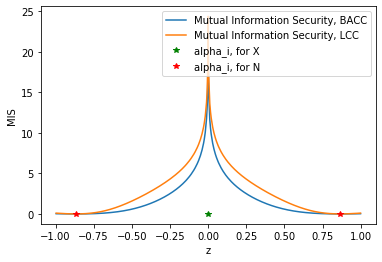

-0.9960065472726245 0.024246284094422223
-0.9945806304055294 0.02379138948912273
-0.993493820294377 0.02344658388246322
-0.9915948270662338 0.02284811569959494
-0.9898654400800284 0.02230760460521098
-0.9897014327908784 0.022256570490235782
-0.988038212984107 0.021741257534331246
-0.9855355914753883 0.020973626381079663
-0.9836359338139788 0.02039727443095157
-0.9833772703799692 0.0203192250498566
-0.9788318268364826 0.018964774051525496
-0.9759626600991576 0.01812685312430741
-0.9747165405337235 0.01776714244762389
-0.9733447938473296 0.0173741628752302
-0.9711924567729937 0.016763972611583335
-0.9674330021665809 0.015717351079513994
-0.9652858824012636 0.015130801675177045
-0.9652457929172171 0.015119928807473135
-0.9642087780812734 0.014839687334542639
-0.9638938590998354 0.014754971483028234
-0.9621416084416963 0.014286926257770411
-0.9599432872341076 0.013707798213239565
-0.9593561339584071 0.01355465651173764
-0.9586057977696858 0.013359906725444062
-0.9575513224099064 0.01308803

-0.21601643520851632 2.936114907964704
-0.21482291810189036 2.952669700116319
-0.2138619533665631 2.9660645131722596
-0.21102352244253209 3.0059761127642646
-0.20869144038840615 3.0391627126063656
-0.20825602812902444 3.0453989380058952
-0.20780185836614273 3.0519173954357286
-0.20194191698088693 3.1372908490862805
-0.20051748488093213 3.158407685309725
-0.19999485756051416 3.1661920921550553
-0.19584463945328867 3.228719489839688
-0.19121690454129636 3.299975417605105
-0.1907532743252467 3.3072060677754025
-0.19039175227583716 3.3128560868763848
-0.1899624246263356 3.319579310327534
-0.18739512473707354 3.360092530780653
-0.18698528972676431 3.3666095921654775
-0.18373507469116102 3.4187881242197378
-0.18113884958256787 3.4611126560919256
-0.17937794199732138 3.490154460430079
-0.1775175647730476 3.521137433791579
-0.1745138247141691 3.571830065883337
-0.17318041639174186 3.5946038161512948
-0.1730496697540147 3.5968459868799765
-0.17061225489905563 3.6389472109770202
-0.1698676542007

In [36]:
K = 1
T = 2
Noise_Alloc = [0,2]
sigma = 1

N = 2

j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T)))

i_array = np.array(range(N))
beta_array = np.cos(i_array*2*math.pi/(N-1)/2) # np.cos(i_array*2*math.pi/N/2)
# print("z_array: ",z_array,'\n')

N = 1000
z_array = np.random.uniform(-1,1,N) #np.cos(i_array[1:]*2*math.pi/(K+T)/2) # np.cos(i_array*2*math.pi/N/2)
z_array = np.sort(z_array)
MIS_array = np.zeros((N))
MIS_LCC_array = np.zeros((N))
# print(z_array)

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)

B = [0.5, 1, 1.5, 2]

z_array_0 = []
z_array_1 = []
z_array_2 = []
z_array_3 = []
z_array_4 = []

for j in range(len(z_array)):
    MIS_array[j] = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma)
    MIS_LCC_array[j] = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma, _is_LCC=True)
    
    if MIS_array[j] < B[0]:
        z_array_0.append(z_array[j])
    elif MIS_array[j] < B[1]:
        z_array_1.append(z_array[j])
    elif MIS_array[j] < B[2]:
        z_array_2.append(z_array[j])
    elif MIS_array[j] < B[3]:
        z_array_3.append(z_array[j])
    else:
        z_array_4.append(z_array[j])
#     print('(beta index, MIS) = ',j,',',MIS_array[j])
#     print()



print(len(z_array_0),len(z_array_1),len(z_array_2),len(z_array_3),len(z_array_4))


plt.plot(z_array, MIS_array, label='Mutual Information Security, BACC')
plt.plot(z_array, MIS_LCC_array, label='Mutual Information Security, LCC')
plt.plot(alpha_array[Signal_Alloc],0*np.ones(len(Signal_Alloc)),'g*',label='alpha_i, for X')
plt.plot(alpha_array[Noise_Alloc],0*np.ones(len(Noise_Alloc)),'r*',label='alpha_i, for N')
# plt.plot(beta_array,0*np.ones(len(beta_array)),'b.',label='beta_i')
plt.xlabel('z')
plt.ylabel('MIS')
plt.legend()
plt.show()
    
for i in range(len(z_array)):
    print(z_array[i],MIS_array[i])
    
# print(alpha_array[Signal_Alloc])
# print(alpha_array[Noise_Alloc])
# print(alpha_array)

# plt.plot((2*j_array[Signal_Alloc]+1)/(K+T),alpha_array[Signal_Alloc],'g*',label='alpha_i, for X')
# plt.plot((2*j_array[Noise_Alloc]+1)/(K+T),alpha_array[Noise_Alloc],'r*',label='alpha_i, for N')
# plt.plot(2*i_array[1:]/(K+T), z_array,'b.',label='beta_i')
# plt.legend()
# plt.show()

In [50]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

N = 8
K = 4
G = 4

size_per_group = int(60000/G)

X_group = np.reshape(encoding_input_array_np, (G,size_per_group,28*28))
y_group = np.reshape(encoding_label_array_np, (G,size_per_group,args.num_classes)) 


N_i = int(N/G) # = 2
K_i = int(K/G) # = 2
T = 2
sigma = 1
Noise_Alloc = [0,2]
m = N_i # number of selected workers (if there is no straggler, m=N_i)

print(N_i,K_i,T)

Signal_Alloc = []
for i in range(K_i+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K_i+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K_i+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

z_array = np.array([-0.521, 0.521])

B = 0.5

N_trials = 1
N_epochs = 30

loss_test_arr_K4_G4_N8 = np.zeros((N_trials,N_epochs))
acc_test_arr_K4_G4_N8  = np.zeros((N_trials,N_epochs))

for trial_idx in range(N_trials):
    
    print('##########################################')
    print('######',trial_idx,'-th Trial!! ###########')
    
    net_glob = CNNMnist2(args=args)
    net_glob.cuda()
    net_glob.train()
    
    # copy weights
    w_glob = net_glob.state_dict()
    
    X_tilde = np.empty((N,Size_submatrices,28*28))
    y_tilde = np.empty((N,Size_submatrices,10))
    
    for G_idx in range(G):
        
        _Noise_label = np.ones((size_per_group*T,10)) * 0.1
        
        X_tilde_tmp,a,b = BACC_Enc_Data_v3(X_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde_tmp,a,b = BACC_Enc_Data_v3(y_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)
        
        stt_pos = G_idx * N_i
        end_pos = (G_idx+1) * N_i
        
        X_tilde[stt_pos:end_pos,:,:] = X_tilde_tmp
        y_tilde[stt_pos:end_pos,:,:] = y_tilde_tmp
        
   

    for iter in range(N_epochs): #args.epochs
        
        w_group_array = []
        for G_idx in range(G):
            w_locals, loss_locals = [], []
            idxs_users = np.random.choice(range(N_i), m, replace=False)
            idxs_users = np.sort(idxs_users)
            print('selected users:',idxs_users)

            coded_net = BACC_Enc_Model_withNoise_v3(net_glob.cuda(), N_i, K_i, T, 0.01, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

            dec_z_array = []
            for idx in idxs_users: #for idx in range(N):
        #         print(idx)
                local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[G_idx*N_i+idx,:,:], label=y_tilde[G_idx*N_i+idx,:,:])
                w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
#                 w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))

                dec_z_array.append(z_array[idx])


            # update global weights
            #w_glob = FedAvg(w_locals)
            w_group = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)
            
            w_group_array.append(copy.deepcopy(w_group))
        
        w_glob = copy.deepcopy(w_group_array[0])
        for k in w_glob.keys():
            for G_idx in range(1,G):
                w_glob[k] += w_group_array[G_idx][k]
            w_glob[k] = torch.div(w_glob[k], len(w_group_array))
        
        # copy weight to net_glob
        net_glob.load_state_dict(w_glob)

        # print loss
    #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

    #     loss_train_arr.append(loss_train)

        acc_test, loss_test = test_img(net_glob, dataset_test, args)
        acc_test_arr_K4_G4_N8[trial_idx][iter] = acc_test
        loss_test_arr_K4_G4_N8[trial_idx][iter] = loss_test

        
        
    

2 1 2
##########################################
###### 0 -th Trial!! ###########
@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

selected users: [0 1]
selected users: [0 1]
selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

selected users: [0 1]
selected users: [0 1]
selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 2.3026 
Accuracy: 958/10000 (9.58%)

selected users: [0 1]
selected users: [0 1]
selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 2.3025 
Accuracy: 794/10000 (7.94%)

selected users: [0 1]
selected users: [0 1]
selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 2.3026 
Accuracy: 974/10000 (9.74%)

selected users: [0 1]


In [29]:
acc_test_arr_K4_G2_N4 = acc_test_arr_G2

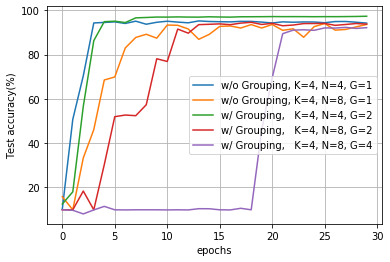

In [58]:
B_sel = 0

# plt.plot(acc_test_arr_v1[0,B_sel,0,0:30],label='N=2, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_K4_G1[2,B_sel,0,0:30],label='w/o Grouping, K=4, N=4, G=1' )
plt.plot(acc_test_arr_K4_G1[3,B_sel,0,0:30],label='w/o Grouping, K=4, N=8, G=1' )
# plt.plot(acc_test_arr_v1[2,B_sel,0,0:30],label='N=6, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v1[3,B_sel,0,0:30],label='N=8, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_K4_G2_N4[0,0:30],label='w/ Grouping,   K=4, N=4, G=2')
plt.plot(acc_test_arr_K4_G2_N8[0,0:30],label='w/ Grouping,   K=4, N=8, G=2')
plt.plot(acc_test_arr_K4_G4_N8[0,0:30],label='w/ Grouping,   K=4, N=8, G=4')
# plt.plot(acc_test_arr_G3[0,0:30],label='Grouping, N=6, G=3, B='+str(B_array[B_sel]))

# plt.plot(acc_test_arr_v1[4,B_sel,0,0:30],label='N=7, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v1[5,B_sel,0,0:30],label='N=8, B='+str(B_array[B_sel]))

# plt.plot(plot_acc_v2[2,sigma_sel,:],label='T=10')
# plt.plot(plot_acc_v2[3,sigma_sel,:],label='T=11')

# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

# 5. Without model encoding

In [44]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

K = 4
T = 5
sigma = 1
Noise_Alloc = [0,2,4,6,8]

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [8]
B_array = [0.5]

N_trials = 1
N_epochs = 30



loss_test_arr_K4_G1_v2 = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))
acc_test_arr_K4_G1_v2  = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))

for N_idx in range(len(N_array)):
    
    N = N_array[N_idx]
    
    
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for B_idx in range(len(B_array)):
        
        B = B_array[B_idx]
        z_array = []
#         while(len(z_array)<N):
#             z_tmp = np.random.uniform(-1,1,1)
#             MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
#             if MIS_tmp < B and MIS_tmp > 0.1:
#                 z_array.append(z_tmp[0])
#         
#         z_array = np.sort(z_array)

        if N==2:
            z_array = np.array([-0.81, 0.81])
        elif N ==4:
            z_array = np.array([-0.81, -0.22, 0.22, 0.81])
        elif N ==5:
            z_array = np.array([-0.81, -0.22, 0, 0.22, 0.81])
        elif N ==6:
            z_array = np.array([-0.9, -0.81, -0.22, 0.22, 0.81, 0.9])
        elif N ==7:
            z_array = np.array([-0.9, -0.82, -0.21, 0, 0.21, 0.82, 0.9])
        else:
            z_array = np.array([-0.94, -0.73, -0.534, -0.125, 0.125, 0.534, 0.73, 0.94])
#             z_array = np.array([-0.9, -0.81, -0.22, -0.20, 0.20, 0.22, 0.81, 0.9])
            
        print('z_array:',z_array)
        for j in range(len(z_array)):
            print(MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma))
        
        
        _Noise_label = np.ones((15000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNMnist2(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
                coded_net = BACC_Enc_Model_withNoise_v3(net_glob.cuda(), N, K, T, 0.01, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
#                     w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                    w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_K4_G1_v2[N_idx][B_idx][trial_idx][iter] = acc_test
                loss_test_arr_K4_G1_v2[N_idx][B_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

z_array: [-0.94  -0.73  -0.534 -0.125  0.125  0.534  0.73   0.94 ]
0.4486236179368535
0.49983046821646326
0.48963480280841937
0.4857187736123886
0.48571877361238697
0.4896348028084205
0.4998304682164621
0.4486236179368556
@BACC_Enc: N,K,T, m_i= 8 4 5 15000 

@BACC_Enc: N,K,T, m_i= 8 4 5 15000 

(T, sigma)= 5 1 )  0 -th Trial!!
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   1, Average loss 2.303 Test accuracy 9.800
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 2.2877 
Accuracy: 3944/10000 (39.44%)

Round   2, Average loss 2.288 Test accuracy 39.440
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 2.0699 
Accuracy: 7961/10000 (79.61%)

Round   3, Average loss 2.070 Test accuracy 79.610
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 1.7928 
Accuracy: 9264

In [45]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

G = 2
N = 4 # N should be divisible by G
K = 4 # N should be divisible by G

size_per_group = int(60000/G)

X_group = np.reshape(encoding_input_array_np, (G,size_per_group,28*28))
y_group = np.reshape(encoding_label_array_np, (G,size_per_group,args.num_classes)) 

N_i = int(N/G) # = 2
K_i = int(K/G) # = 2
T = 3
sigma = 1
Noise_Alloc = [0,2,4]
m = N_i # number of selected workers (if there is no straggler, m=N_i)

print(N_i,K_i,T)

Signal_Alloc = []
for i in range(K_i+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K_i+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K_i+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

z_array = np.array([-0.81, 0.81])

B = 0.5

N_trials = 1
N_epochs = 30

loss_test_arr_G2_N4_v2 = np.zeros((N_trials,N_epochs))
acc_test_arr_G2_N4_v2  = np.zeros((N_trials,N_epochs))

for trial_idx in range(N_trials):
    
    print('##########################################')
    print('######',trial_idx,'-th Trial!! ###########')
    
    net_glob = CNNMnist2(args=args)
    net_glob.cuda()
    net_glob.train()
    
    # copy weights
    w_glob = net_glob.state_dict()
    
    X_tilde = np.empty((N,Size_submatrices,28*28))
    y_tilde = np.empty((N,Size_submatrices,10))
    
    for G_idx in range(G):
        
        _Noise_label = np.ones((size_per_group*T,10)) * 0.1
        
        X_tilde_tmp,a,b = BACC_Enc_Data_v3(X_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde_tmp,a,b = BACC_Enc_Data_v3(y_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)
        
        stt_pos = G_idx * N_i
        end_pos = (G_idx+1) * N_i
        
        X_tilde[stt_pos:end_pos,:,:] = X_tilde_tmp
        y_tilde[stt_pos:end_pos,:,:] = y_tilde_tmp
        
   

    for iter in range(N_epochs): #args.epochs
        
        w_group_array = []
        for G_idx in range(G):
            w_locals, loss_locals = [], []
            idxs_users = np.random.choice(range(N_i), m, replace=False)
            idxs_users = np.sort(idxs_users)
            print('selected users:',idxs_users)

#             coded_net = BACC_Enc_Model_withNoise_v3(net_glob.cuda(), N_i, K_i, T, 0.01, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

            dec_z_array = []
            for idx in idxs_users: #for idx in range(N):
        #         print(idx)
                local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[G_idx*N_i+idx,:,:], label=y_tilde[G_idx*N_i+idx,:,:])
#                 w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))

                dec_z_array.append(z_array[idx])


            # update global weights
            #w_glob = FedAvg(w_locals)
            w_group = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)
            
            w_group_array.append(copy.deepcopy(w_group))
        
        w_glob = copy.deepcopy(w_group_array[0])
        for k in w_glob.keys():
            for G_idx in range(1,G):
                w_glob[k] += w_group_array[G_idx][k]
            w_glob[k] = torch.div(w_glob[k], len(w_group_array))
        
        # copy weight to net_glob
        net_glob.load_state_dict(w_glob)

        # print loss
    #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

    #     loss_train_arr.append(loss_train)

        acc_test, loss_test = test_img(net_glob, dataset_test, args)
        acc_test_arr_G2_N4_v2[trial_idx][iter] = acc_test
        loss_test_arr_G2_N4_v2[trial_idx][iter] = loss_test

        
        
    

2 2 3
##########################################
###### 0 -th Trial!! ###########
@BACC_Enc: N,K,T, m_i= 2 2 3 15000 

@BACC_Enc: N,K,T, m_i= 2 2 3 15000 

@BACC_Enc: N,K,T, m_i= 2 2 3 15000 

@BACC_Enc: N,K,T, m_i= 2 2 3 15000 

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 2.2202 
Accuracy: 4077/10000 (40.77%)

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 0.7585 
Accuracy: 8011/10000 (80.11%)

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 0.2700 
Accuracy: 9568/10000 (95.68%)

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 0.1997 
Accuracy: 9657/10000 (96.57%)

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 0.2082 
Accuracy: 9679/10000 (96.79%)

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 0.1947 
Accuracy: 9698/10000 (96.98%)

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 0.2030 
Accuracy: 9723/10000 (97.23%)

selected users

In [46]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

N = 8
K = 4
G = 2

N_i = int(N/G) # = 2
K_i = int(K/G) # = 2
T = 3
sigma = 1
Noise_Alloc = [0,2,4]
m = N_i # number of selected workers (if there is no straggler, m=N_i)

print(N_i,K_i,T)

Signal_Alloc = []
for i in range(K_i+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K_i+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K_i+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

z_array = np.array([-0.81, -0.22, 0.22, 0.81])

B = 0.5

N_trials = 1
N_epochs = 30

loss_test_arr_K4_G2_N8_v2 = np.zeros((N_trials,N_epochs))
acc_test_arr_K4_G2_N8_v2  = np.zeros((N_trials,N_epochs))

for trial_idx in range(N_trials):
    
    print('##########################################')
    print('######',trial_idx,'-th Trial!! ###########')
    
    net_glob = CNNMnist2(args=args)
    net_glob.cuda()
    net_glob.train()
    
    # copy weights
    w_glob = net_glob.state_dict()
    
    X_tilde = np.empty((N,Size_submatrices,28*28))
    y_tilde = np.empty((N,Size_submatrices,10))
    
    for G_idx in range(G):
        
        _Noise_label = np.ones((size_per_group*T,10)) * 0.1
        
        X_tilde_tmp,a,b = BACC_Enc_Data_v3(X_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde_tmp,a,b = BACC_Enc_Data_v3(y_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)
        
        stt_pos = G_idx * N_i
        end_pos = (G_idx+1) * N_i
        
        X_tilde[stt_pos:end_pos,:,:] = X_tilde_tmp
        y_tilde[stt_pos:end_pos,:,:] = y_tilde_tmp
        
   

    for iter in range(N_epochs): #args.epochs
        
        w_group_array = []
        for G_idx in range(G):
            w_locals, loss_locals = [], []
            idxs_users = np.random.choice(range(N_i), m, replace=False)
            idxs_users = np.sort(idxs_users)
            print('selected users:',idxs_users)

#             coded_net = BACC_Enc_Model_withNoise_v3(net_glob.cuda(), N_i, K_i, T, 0.01, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

            dec_z_array = []
            for idx in idxs_users: #for idx in range(N):
        #         print(idx)
                local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[G_idx*N_i+idx,:,:], label=y_tilde[G_idx*N_i+idx,:,:])
#                 w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))

                dec_z_array.append(z_array[idx])


            # update global weights
            #w_glob = FedAvg(w_locals)
            w_group = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)
            
            w_group_array.append(copy.deepcopy(w_group))
        
        w_glob = copy.deepcopy(w_group_array[0])
        for k in w_glob.keys():
            for G_idx in range(1,G):
                w_glob[k] += w_group_array[G_idx][k]
            w_glob[k] = torch.div(w_glob[k], len(w_group_array))
        
        # copy weight to net_glob
        net_glob.load_state_dict(w_glob)

        # print loss
    #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

    #     loss_train_arr.append(loss_train)

        acc_test, loss_test = test_img(net_glob, dataset_test, args)
        acc_test_arr_K4_G2_N8_v2[trial_idx][iter] = acc_test
        loss_test_arr_K4_G2_N8_v2[trial_idx][iter] = loss_test

        
        
    

4 2 3
##########################################
###### 0 -th Trial!! ###########
@BACC_Enc: N,K,T, m_i= 4 2 3 15000 

@BACC_Enc: N,K,T, m_i= 4 2 3 15000 

@BACC_Enc: N,K,T, m_i= 4 2 3 15000 

@BACC_Enc: N,K,T, m_i= 4 2 3 15000 

selected users: [0 1 2 3]
selected users: [0 1 2 3]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

selected users: [0 1 2 3]
selected users: [0 1 2 3]

Test set: Average loss: 2.3025 
Accuracy: 974/10000 (9.74%)

selected users: [0 1 2 3]
selected users: [0 1 2 3]

Test set: Average loss: 2.2943 
Accuracy: 2544/10000 (25.44%)

selected users: [0 1 2 3]
selected users: [0 1 2 3]

Test set: Average loss: 2.0631 
Accuracy: 6656/10000 (66.56%)

selected users: [0 1 2 3]
selected users: [0 1 2 3]

Test set: Average loss: 1.9568 
Accuracy: 8542/10000 (85.42%)

selected users: [0 1 2 3]
selected users: [0 1 2 3]

Test set: Average loss: 1.8062 
Accuracy: 9612/10000 (96.12%)

selected users: [0 1 2 3]
selected users: [0 1 2 3]

Test set: Average loss: 1

In [47]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

N = 8
K = 4
G = 4

size_per_group = int(60000/G)

X_group = np.reshape(encoding_input_array_np, (G,size_per_group,28*28))
y_group = np.reshape(encoding_label_array_np, (G,size_per_group,args.num_classes)) 


N_i = int(N/G) # = 2
K_i = int(K/G) # = 2
T = 2
sigma = 1
Noise_Alloc = [0,2]
m = N_i # number of selected workers (if there is no straggler, m=N_i)

print(N_i,K_i,T)

Signal_Alloc = []
for i in range(K_i+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K_i+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K_i+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

z_array = np.array([-0.521, 0.521])

B = 0.5

N_trials = 1
N_epochs = 30

loss_test_arr_K4_G4_N8_v2 = np.zeros((N_trials,N_epochs))
acc_test_arr_K4_G4_N8_v2  = np.zeros((N_trials,N_epochs))

for trial_idx in range(N_trials):
    
    print('##########################################')
    print('######',trial_idx,'-th Trial!! ###########')
    
    net_glob = CNNMnist2(args=args)
    net_glob.cuda()
    net_glob.train()
    
    # copy weights
    w_glob = net_glob.state_dict()
    
    X_tilde = np.empty((N,Size_submatrices,28*28))
    y_tilde = np.empty((N,Size_submatrices,10))
    
    for G_idx in range(G):
        
        _Noise_label = np.ones((size_per_group*T,10)) * 0.1
        
        X_tilde_tmp,a,b = BACC_Enc_Data_v3(X_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde_tmp,a,b = BACC_Enc_Data_v3(y_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)
        
        stt_pos = G_idx * N_i
        end_pos = (G_idx+1) * N_i
        
        X_tilde[stt_pos:end_pos,:,:] = X_tilde_tmp
        y_tilde[stt_pos:end_pos,:,:] = y_tilde_tmp
        
   

    for iter in range(N_epochs): #args.epochs
        
        w_group_array = []
        for G_idx in range(G):
            w_locals, loss_locals = [], []
            idxs_users = np.random.choice(range(N_i), m, replace=False)
            idxs_users = np.sort(idxs_users)
            print('selected users:',idxs_users)

            coded_net = BACC_Enc_Model_withNoise_v3(net_glob.cuda(), N_i, K_i, T, 0.01, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

            dec_z_array = []
            for idx in idxs_users: #for idx in range(N):
        #         print(idx)
                local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[G_idx*N_i+idx,:,:], label=y_tilde[G_idx*N_i+idx,:,:])
#                 w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))

                dec_z_array.append(z_array[idx])


            # update global weights
            #w_glob = FedAvg(w_locals)
            w_group = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)
            
            w_group_array.append(copy.deepcopy(w_group))
        
        w_glob = copy.deepcopy(w_group_array[0])
        for k in w_glob.keys():
            for G_idx in range(1,G):
                w_glob[k] += w_group_array[G_idx][k]
            w_glob[k] = torch.div(w_glob[k], len(w_group_array))
        
        # copy weight to net_glob
        net_glob.load_state_dict(w_glob)

        # print loss
    #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

    #     loss_train_arr.append(loss_train)

        acc_test, loss_test = test_img(net_glob, dataset_test, args)
        acc_test_arr_K4_G4_N8_v2[trial_idx][iter] = acc_test
        loss_test_arr_K4_G4_N8_v2[trial_idx][iter] = loss_test

        
        
    

2 1 2
##########################################
###### 0 -th Trial!! ###########
@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

selected users: [0 1]
selected users: [0 1]
selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

selected users: [0 1]
selected users: [0 1]
selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 2.2967 
Accuracy: 4766/10000 (47.66%)

selected users: [0 1]
selected users: [0 1]
selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 1.9995 
Accuracy: 7548/10000 (75.48%)

selected users: [0 1]
selected users: [0 1]
selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 1.8282 
Accuracy: 9493/10000 (94.93%)

selected users: 

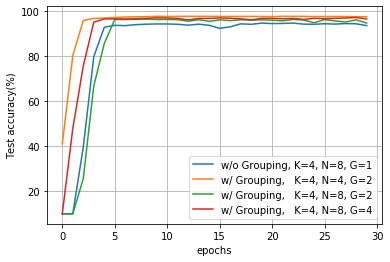

In [49]:
B_sel = 0

# plt.plot(acc_test_arr_v1[0,B_sel,0,0:30],label='N=2, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_K4_G1_v2[0,B_sel,0,0:30],label='w/o Grouping, K=4, N=8, G=1' )
# plt.plot(acc_test_arr_v1[2,B_sel,0,0:30],label='N=6, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v1[3,B_sel,0,0:30],label='N=8, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_G2_N4_v2[0,0:30],label='w/ Grouping,   K=4, N=4, G=2')
plt.plot(acc_test_arr_K4_G2_N8_v2[0,0:30],label='w/ Grouping,   K=4, N=8, G=2')
plt.plot(acc_test_arr_K4_G4_N8_v2[0,0:30],label='w/ Grouping,   K=4, N=8, G=4')
# plt.plot(acc_test_arr_G3[0,0:30],label='Grouping, N=6, G=3, B='+str(B_array[B_sel]))

# plt.plot(acc_test_arr_v1[4,B_sel,0,0:30],label='N=7, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v1[5,B_sel,0,0:30],label='N=8, B='+str(B_array[B_sel]))

# plt.plot(plot_acc_v2[2,sigma_sel,:],label='T=10')
# plt.plot(plot_acc_v2[3,sigma_sel,:],label='T=11')

# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

# 6. Fix the model encoding

In [70]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

K = 4
T = 5
sigma = 1
Noise_Alloc = [0,2,4,6,8]

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [4, 8]
B_array = [0.5]

N_trials = 5
N_epochs = 30



loss_test_arr_K4_G1_v3 = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))
acc_test_arr_K4_G1_v3  = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))

for N_idx in range(len(N_array)):
    
    N = N_array[N_idx]
    
    
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for B_idx in range(len(B_array)):
        
        B = B_array[B_idx]
        z_array = []
#         while(len(z_array)<N):
#             z_tmp = np.random.uniform(-1,1,1)
#             MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
#             if MIS_tmp < B and MIS_tmp > 0.1:
#                 z_array.append(z_tmp[0])
#         
#         z_array = np.sort(z_array)
        print(N_idx,'!!!')
        if N_idx==0:
            z_array = np.array([-0.94,-0.534,0.534, 0.94])
#         elif N_idx==1:
#             z_array = np.array([-0.94, -0.73, 0.73, 0.94])
#         elif N_idx==2:
#             z_array = np.array([-0.94, -0.125, 0.125, 0.94])
        else:
            z_array = np.array([-0.94, -0.73, -0.534, -0.125, 0.125, 0.534, 0.73, 0.94])
#             z_array = np.array([-0.9, -0.81, -0.22, -0.20, 0.20, 0.22, 0.81, 0.9])
            
        print('z_array:',z_array)
        for j in range(len(z_array)):
            print(MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma))
        
        
        _Noise_label = np.ones((15000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNMnist2(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
                coded_net = BACC_Enc_Model_withNoise_v4(net_glob.cuda(), N, K, T, 1, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                    w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
#                     w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_K4_G1_v3[N_idx][B_idx][trial_idx][iter] = acc_test
                loss_test_arr_K4_G1_v3[N_idx][B_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

0 !!!
z_array: [-0.94  -0.534  0.534  0.94 ]
0.4486236179368535
0.48963480280841937
0.4896348028084205
0.4486236179368556
@BACC_Enc: N,K,T, m_i= 4 4 5 15000 

@BACC_Enc: N,K,T, m_i= 4 4 5 15000 

(T, sigma)= 5 1 )  0 -th Trial!!
selected users: [0 1 2 3]
conv1.weight 0.012616732120513917
conv1.bias 0.012467783875763416
conv2.weight 0.00041515901684761045
conv2.bias 0.00041941372910514474
fc1.weight 0.00032443224918097255
fc1.bias 0.00031529138796031474

Test set: Average loss: 2.2659 
Accuracy: 2814/10000 (28.14%)

Round   0, Average loss 2.266 Test accuracy 28.140
selected users: [0 1 2 3]
conv1.weight 0.0011088134348392488
conv1.bias 0.007187981624156237
conv2.weight 0.0008096638321876526
conv2.bias 0.0017347087850794196
fc1.weight 0.0003073048545047641
fc1.bias 0.0022951560094952583

Test set: Average loss: 1.5107 
Accuracy: 6144/10000 (61.44%)

Round   1, Average loss 1.511 Test accuracy 61.440
selected users: [0 1 2 3]
conv1.weight 0.0005380341038107872
conv1.bias 0.02010150998830


Test set: Average loss: 0.4283 
Accuracy: 9088/10000 (90.88%)

Round  23, Average loss 0.428 Test accuracy 90.880
selected users: [0 1 2 3]
conv1.weight 0.001175582855939865
conv1.bias 0.014385771937668324
conv2.weight 0.00045420754700899125
conv2.bias 0.0033040321432054043
fc1.weight 0.0008197194896638393
fc1.bias 0.002220488712191582

Test set: Average loss: 0.5204 
Accuracy: 8802/10000 (88.02%)

Round  24, Average loss 0.520 Test accuracy 88.020
selected users: [0 1 2 3]
conv1.weight 0.0008326202630996704
conv1.bias 0.015181787312030792
conv2.weight 0.0005527037754654885
conv2.bias 0.0035513113252818584
fc1.weight 0.0008252165280282497
fc1.bias 0.003114721179008484

Test set: Average loss: 0.4303 
Accuracy: 9069/10000 (90.69%)

Round  25, Average loss 0.430 Test accuracy 90.690
selected users: [0 1 2 3]
conv1.weight 0.000979602113366127
conv1.bias 0.014020392671227455
conv2.weight 0.0004993779584765434
conv2.bias 0.003304543439298868
fc1.weight 0.0010365263558924198
fc1.bias 0.0047


Test set: Average loss: 0.4433 
Accuracy: 9119/10000 (91.19%)

Round  18, Average loss 0.443 Test accuracy 91.190
selected users: [0 1 2 3]
conv1.weight 0.0008736420422792435
conv1.bias 0.015051376074552536
conv2.weight 0.0006572893261909485
conv2.bias 0.0032999401446431875
fc1.weight 0.0010530371218919754
fc1.bias 0.004160522669553757

Test set: Average loss: 0.4432 
Accuracy: 9081/10000 (90.81%)

Round  19, Average loss 0.443 Test accuracy 90.810
selected users: [0 1 2 3]
conv1.weight 0.0016315473616123199
conv1.bias 0.020036358386278152
conv2.weight 0.0004684704914689064
conv2.bias 0.002969155553728342
fc1.weight 0.0009581705555319787
fc1.bias 0.0031894464045763016

Test set: Average loss: 0.4704 
Accuracy: 9041/10000 (90.41%)

Round  20, Average loss 0.470 Test accuracy 90.410
selected users: [0 1 2 3]
conv1.weight 0.0015988081693649292
conv1.bias 0.02232244238257408
conv2.weight 0.0003395748883485794
conv2.bias 0.0029189586639404297
fc1.weight 0.0008388116024434566
fc1.bias 0.002


Test set: Average loss: 0.4158 
Accuracy: 9168/10000 (91.68%)

Round  13, Average loss 0.416 Test accuracy 91.680
selected users: [0 1 2 3]
conv1.weight 0.001324448436498642
conv1.bias 0.022601254284381866
conv2.weight 0.00047714821994304657
conv2.bias 0.002766302553936839
fc1.weight 0.0011894961819052697
fc1.bias 0.003943328559398651

Test set: Average loss: 0.4159 
Accuracy: 9141/10000 (91.41%)

Round  14, Average loss 0.416 Test accuracy 91.410
selected users: [0 1 2 3]
conv1.weight 0.0011974452435970307
conv1.bias 0.018507227301597595
conv2.weight 0.0004209556430578232
conv2.bias 0.0026745202485471964
fc1.weight 0.000991460494697094
fc1.bias 0.003810575231909752

Test set: Average loss: 0.4201 
Accuracy: 9126/10000 (91.26%)

Round  15, Average loss 0.420 Test accuracy 91.260
selected users: [0 1 2 3]
conv1.weight 0.0011593854427337646
conv1.bias 0.022156964987516403
conv2.weight 0.00042661584913730624
conv2.bias 0.003273359499871731
fc1.weight 0.0011763926595449448
fc1.bias 0.0032


Test set: Average loss: 0.4758 
Accuracy: 8948/10000 (89.48%)

Round   8, Average loss 0.476 Test accuracy 89.480
selected users: [0 1 2 3]
conv1.weight 0.0011985206604003906
conv1.bias 0.01862991228699684
conv2.weight 0.0005391519889235497
conv2.bias 0.0038108541630208492
fc1.weight 0.0008593806996941566
fc1.bias 0.005797397717833519

Test set: Average loss: 0.5074 
Accuracy: 8965/10000 (89.65%)

Round   9, Average loss 0.507 Test accuracy 89.650
selected users: [0 1 2 3]
conv1.weight 0.0010294896364212037
conv1.bias 0.017067531123757362
conv2.weight 0.0006431344151496887
conv2.bias 0.0037859799340367317
fc1.weight 0.0006634674966335297
fc1.bias 0.003930662199854851

Test set: Average loss: 0.5180 
Accuracy: 8963/10000 (89.63%)

Round  10, Average loss 0.518 Test accuracy 89.630
selected users: [0 1 2 3]
conv1.weight 0.0009827519953250884
conv1.bias 0.01579016074538231
conv2.weight 0.0007383423298597336
conv2.bias 0.003875371068716049
fc1.weight 0.0008583059534430504
fc1.bias 0.00433


Test set: Average loss: 0.4624 
Accuracy: 9060/10000 (90.60%)

Round   3, Average loss 0.462 Test accuracy 90.600
selected users: [0 1 2 3]
conv1.weight 0.0009344609081745148
conv1.bias 0.018278449773788452
conv2.weight 0.0005759219452738762
conv2.bias 0.003783551510423422
fc1.weight 0.0009343058802187443
fc1.bias 0.003958434984087944

Test set: Average loss: 0.4095 
Accuracy: 9138/10000 (91.38%)

Round   4, Average loss 0.410 Test accuracy 91.380
selected users: [0 1 2 3]
conv1.weight 0.0008392563462257385
conv1.bias 0.015229474753141403
conv2.weight 0.0005753423273563385
conv2.bias 0.003619065973907709
fc1.weight 0.0010392120108008384
fc1.bias 0.003698892518877983

Test set: Average loss: 0.3973 
Accuracy: 9144/10000 (91.44%)

Round   5, Average loss 0.397 Test accuracy 91.440
selected users: [0 1 2 3]
conv1.weight 0.0010322915762662887
conv1.bias 0.01623060181736946
conv2.weight 0.0005421213433146477
conv2.bias 0.003654582193121314
fc1.weight 0.0010152162984013557
fc1.bias 0.002686


Test set: Average loss: 0.3865 
Accuracy: 9218/10000 (92.18%)

Round  28, Average loss 0.387 Test accuracy 92.180
selected users: [0 1 2 3]
conv1.weight 0.0015293341875076295
conv1.bias 0.02377348579466343
conv2.weight 0.000517510287463665
conv2.bias 0.002888001501560211
fc1.weight 0.001115255244076252
fc1.bias 0.0038615543395280837

Test set: Average loss: 0.4165 
Accuracy: 9186/10000 (91.86%)

Round  29, Average loss 0.417 Test accuracy 91.860
1 !!!
z_array: [-0.94  -0.73  -0.534 -0.125  0.125  0.534  0.73   0.94 ]
0.4486236179368535
0.49983046821646326
0.48963480280841937
0.4857187736123886
0.48571877361238697
0.4896348028084205
0.4998304682164621
0.4486236179368556
@BACC_Enc: N,K,T, m_i= 8 4 5 15000 

@BACC_Enc: N,K,T, m_i= 8 4 5 15000 

(T, sigma)= 5 1 )  0 -th Trial!!
selected users: [0 1 2 3 4 5 6 7]
conv1.weight 0.014268984794616699
conv1.bias 0.01169295608997345
conv2.weight 0.0004176216199994087
conv2.bias 0.00043653909233398736
fc1.weight 0.0003244195831939578
fc1.bias 0.00


Test set: Average loss: 2.0973 
Accuracy: 7203/10000 (72.03%)

Round  21, Average loss 2.097 Test accuracy 72.030
selected users: [0 1 2 3 4 5 6 7]
conv1.weight 0.00032542333006858827
conv1.bias 0.001976609928533435
conv2.weight 9.268948808312416e-05
conv2.bias 0.0007242119172587991
fc1.weight 0.00015902143204584717
fc1.bias 0.0006433987058699131

Test set: Average loss: 2.1340 
Accuracy: 6070/10000 (60.70%)

Round  22, Average loss 2.134 Test accuracy 60.700
selected users: [0 1 2 3 4 5 6 7]
conv1.weight 0.0003886595368385315
conv1.bias 0.0015512711834162474
conv2.weight 5.6357337161898616e-05
conv2.bias 0.0006658534985035658
fc1.weight 0.00024015111848711966
fc1.bias 0.0006502380128949881

Test set: Average loss: 2.1523 
Accuracy: 5811/10000 (58.11%)

Round  23, Average loss 2.152 Test accuracy 58.110
selected users: [0 1 2 3 4 5 6 7]
conv1.weight 0.00027584198862314226
conv1.bias 0.0020328075625002384
conv2.weight 8.551175706088543e-05
conv2.bias 0.0008602143498137593
fc1.weight 0.


Test set: Average loss: 2.2729 
Accuracy: 4620/10000 (46.20%)

Round  15, Average loss 2.273 Test accuracy 46.200
selected users: [0 1 2 3 4 5 6 7]
conv1.weight 0.0002219069004058838
conv1.bias 0.0015664056409150362
conv2.weight 5.517376586794853e-05
conv2.bias 0.0009361236589029431
fc1.weight 0.0001511220703832805
fc1.bias 0.0006426018662750721

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  16, Average loss 2.303 Test accuracy 9.800
selected users: [0 1 2 3 4 5 6 7]
conv1.weight 0.0003776770457625389
conv1.bias 0.001058701192960143
conv2.weight 0.0001921354793012142
conv2.bias 0.0007832938572391868
fc1.weight 0.00021689170971512796
fc1.bias 0.00018706183182075619

Test set: Average loss: 2.3026 
Accuracy: 1028/10000 (10.28%)

Round  17, Average loss 2.303 Test accuracy 10.280
selected users: [0 1 2 3 4 5 6 7]
conv1.weight 0.00011312151327729225
conv1.bias 0.0017861549276858568
conv2.weight 8.611440658569336e-05
conv2.bias 0.001080622198060155
fc1.weight 5.838455


Test set: Average loss: 2.3016 
Accuracy: 2331/10000 (23.31%)

Round   9, Average loss 2.302 Test accuracy 23.310
selected users: [0 1 2 3 4 5 6 7]
conv1.weight 0.0004921611398458481
conv1.bias 0.0009109588572755456
conv2.weight 6.337635684758425e-05
conv2.bias 0.0010249370243400335
fc1.weight 0.00013810942182317375
fc1.bias 0.00032491902820765974

Test set: Average loss: 2.3019 
Accuracy: 912/10000 (9.12%)

Round  10, Average loss 2.302 Test accuracy 9.120
selected users: [0 1 2 3 4 5 6 7]
conv1.weight 0.00012477299198508264
conv1.bias 0.0015717362985014915
conv2.weight 6.831612903624773e-05
conv2.bias 0.0010691401548683643
fc1.weight 0.00011890687746927143
fc1.bias 0.00027617586310952903

Test set: Average loss: 2.3025 
Accuracy: 992/10000 (9.92%)

Round  11, Average loss 2.303 Test accuracy 9.920
selected users: [0 1 2 3 4 5 6 7]
conv1.weight 0.0001664341241121292
conv1.bias 0.0024730912409722805
conv2.weight 2.9840916395187377e-05
conv2.bias 0.00080812384840101
fc1.weight 0.000141


Test set: Average loss: 2.3020 
Accuracy: 1028/10000 (10.28%)

Round   3, Average loss 2.302 Test accuracy 10.280
selected users: [0 1 2 3 4 5 6 7]
conv1.weight 0.0003184841573238373
conv1.bias 0.0018667385447770357
conv2.weight 6.596929393708706e-05
conv2.bias 0.0011054433416575193
fc1.weight 0.00012640187051147223
fc1.bias 0.0008877666667103767

Test set: Average loss: 2.3025 
Accuracy: 1028/10000 (10.28%)

Round   4, Average loss 2.303 Test accuracy 10.280
selected users: [0 1 2 3 4 5 6 7]
conv1.weight 0.0002659502997994423
conv1.bias 0.0017717157024890184
conv2.weight 7.148840464651584e-05
conv2.bias 0.0008910291362553835
fc1.weight 9.089966770261526e-05
fc1.bias 0.0007561927661299706

Test set: Average loss: 2.3021 
Accuracy: 1386/10000 (13.86%)

Round   5, Average loss 2.302 Test accuracy 13.860
selected users: [0 1 2 3 4 5 6 7]
conv1.weight 0.00023030621930956842
conv1.bias 0.0010378805454820395
conv2.weight 7.66385719180107e-05
conv2.bias 0.0011980815324932337
fc1.weight 0.000


Test set: Average loss: 2.2956 
Accuracy: 2435/10000 (24.35%)

Round  27, Average loss 2.296 Test accuracy 24.350
selected users: [0 1 2 3 4 5 6 7]
conv1.weight 0.0001310382876545191
conv1.bias 0.005856798961758614
conv2.weight 6.887503433972598e-05
conv2.bias 0.0010666692396625876
fc1.weight 6.871458608657122e-05
fc1.bias 0.00022945899982005358

Test set: Average loss: 2.3001 
Accuracy: 3245/10000 (32.45%)

Round  28, Average loss 2.300 Test accuracy 32.450
selected users: [0 1 2 3 4 5 6 7]
conv1.weight 0.0002110094390809536
conv1.bias 0.002177502727136016
conv2.weight 3.162576584145427e-05
conv2.bias 0.0007320907898247242
fc1.weight 0.00023501873947679998
fc1.bias 0.00031605244148522613

Test set: Average loss: 2.2831 
Accuracy: 3705/10000 (37.05%)

Round  29, Average loss 2.283 Test accuracy 37.050
(T, sigma)= 5 1 )  4 -th Trial!!
selected users: [0 1 2 3 4 5 6 7]
conv1.weight 0.013374913930892945
conv1.bias 0.012574296444654465
conv2.weight 0.00041922666132450105
conv2.bias 0.0004


Test set: Average loss: 2.2961 
Accuracy: 1262/10000 (12.62%)

Round  21, Average loss 2.296 Test accuracy 12.620
selected users: [0 1 2 3 4 5 6 7]
conv1.weight 0.0005228253453969955
conv1.bias 0.0010672332718968391
conv2.weight 0.00023090187460184097
conv2.bias 0.0007535008480772376
fc1.weight 0.0002117895521223545
fc1.bias 0.0011671410873532295

Test set: Average loss: 2.2992 
Accuracy: 2339/10000 (23.39%)

Round  22, Average loss 2.299 Test accuracy 23.390
selected users: [0 1 2 3 4 5 6 7]
conv1.weight 0.0003847220167517662
conv1.bias 0.001833084737882018
conv2.weight 8.484448306262494e-05
conv2.bias 0.001161295804195106
fc1.weight 8.420962840318679e-05
fc1.bias 0.0015136186964809894

Test set: Average loss: 2.2260 
Accuracy: 7064/10000 (70.64%)

Round  23, Average loss 2.226 Test accuracy 70.640
selected users: [0 1 2 3 4 5 6 7]
conv1.weight 0.0004291202127933502
conv1.bias 0.00046908273361623287
conv2.weight 7.891953922808171e-05
conv2.bias 0.000752789550460875
fc1.weight 0.00028

In [71]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

G = 2
N = 4 # N should be divisible by G
K = 4 # N should be divisible by G

size_per_group = int(60000/G)

X_group = np.reshape(encoding_input_array_np, (G,size_per_group,28*28))
y_group = np.reshape(encoding_label_array_np, (G,size_per_group,args.num_classes)) 

N_i = int(N/G) # = 2
K_i = int(K/G) # = 2
T = 3
sigma = 1
Noise_Alloc = [0,2,4]
m = N_i # number of selected workers (if there is no straggler, m=N_i)

print(N_i,K_i,T)

Signal_Alloc = []
for i in range(K_i+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K_i+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K_i+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

z_array = np.array([-0.81, 0.81])

B = 0.5

N_trials = 5
N_epochs = 30

loss_test_arr_G2_N4_v3 = np.zeros((N_trials,N_epochs))
acc_test_arr_G2_N4_v3  = np.zeros((N_trials,N_epochs))

for trial_idx in range(N_trials):
    
    print('##########################################')
    print('######',trial_idx,'-th Trial!! ###########')
    
    net_glob = CNNMnist2(args=args)
    net_glob.cuda()
    net_glob.train()
    
    # copy weights
    w_glob = net_glob.state_dict()
    
    X_tilde = np.empty((N,Size_submatrices,28*28))
    y_tilde = np.empty((N,Size_submatrices,10))
    
    for G_idx in range(G):
        
        _Noise_label = np.ones((size_per_group*T,10)) * 0.1
        
        X_tilde_tmp,a,b = BACC_Enc_Data_v3(X_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde_tmp,a,b = BACC_Enc_Data_v3(y_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)
        
        stt_pos = G_idx * N_i
        end_pos = (G_idx+1) * N_i
        
        X_tilde[stt_pos:end_pos,:,:] = X_tilde_tmp
        y_tilde[stt_pos:end_pos,:,:] = y_tilde_tmp
        
   

    for iter in range(N_epochs): #args.epochs
        
        w_group_array = []
        for G_idx in range(G):
            w_locals, loss_locals = [], []
            idxs_users = np.random.choice(range(N_i), m, replace=False)
            idxs_users = np.sort(idxs_users)
            print('selected users:',idxs_users)

            coded_net = BACC_Enc_Model_withNoise_v4(net_glob.cuda(), N_i, K_i, T, 1, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

            dec_z_array = []
            for idx in idxs_users: #for idx in range(N):
        #         print(idx)
                local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[G_idx*N_i+idx,:,:], label=y_tilde[G_idx*N_i+idx,:,:])
                w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
#                 w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))

                dec_z_array.append(z_array[idx])


            # update global weights
            #w_glob = FedAvg(w_locals)
            w_group = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)
            
            w_group_array.append(copy.deepcopy(w_group))
        
        w_glob = copy.deepcopy(w_group_array[0])
        for k in w_glob.keys():
            for G_idx in range(1,G):
                w_glob[k] += w_group_array[G_idx][k]
            w_glob[k] = torch.div(w_glob[k], len(w_group_array))
        
        # copy weight to net_glob
        net_glob.load_state_dict(w_glob)

        # print loss
    #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

    #     loss_train_arr.append(loss_train)

        acc_test, loss_test = test_img(net_glob, dataset_test, args)
        acc_test_arr_G2_N4_v3[trial_idx][iter] = acc_test
        loss_test_arr_G2_N4_v3[trial_idx][iter] = loss_test

        
        
    

2 2 3
##########################################
###### 0 -th Trial!! ###########
@BACC_Enc: N,K,T, m_i= 2 2 3 15000 

@BACC_Enc: N,K,T, m_i= 2 2 3 15000 

@BACC_Enc: N,K,T, m_i= 2 2 3 15000 

@BACC_Enc: N,K,T, m_i= 2 2 3 15000 

selected users: [0 1]
conv1.weight 0.013985772132873536
conv1.bias 0.015298161655664444
conv2.weight 0.000414406917989254
conv2.bias 0.00038662675069645047
fc1.weight 0.00032845877576619386
fc1.bias 0.00034686101134866475
selected users: [0 1]
conv1.weight 0.013985772132873536
conv1.bias 0.015298161655664444
conv2.weight 0.000414406917989254
conv2.bias 0.00038662675069645047
fc1.weight 0.00032845877576619386
fc1.bias 0.00034686101134866475

Test set: Average loss: 2.2987 
Accuracy: 1440/10000 (14.40%)

selected users: [0 1]
conv1.weight 0.0018887656927108764
conv1.bias 0.008341850712895393
conv2.weight 0.0010946141928434372
conv2.bias 0.0018832884961739182
fc1.weight 0.0003517881967127323
fc1.bias 0.0018705600872635842
selected users: [0 1]
conv1.weight 0.0018


Test set: Average loss: 0.2165 
Accuracy: 9656/10000 (96.56%)

selected users: [0 1]
conv1.weight 0.002330783009529114
conv1.bias 0.024221647530794144
conv2.weight 0.0006715203821659088
conv2.bias 0.0032503921538591385
fc1.weight 0.001188305951654911
fc1.bias 0.006067048013210297
selected users: [0 1]
conv1.weight 0.002330783009529114
conv1.bias 0.024221647530794144
conv2.weight 0.0006715203821659088
conv2.bias 0.0032503921538591385
fc1.weight 0.001188305951654911
fc1.bias 0.006067048013210297

Test set: Average loss: 0.2682 
Accuracy: 9625/10000 (96.25%)

selected users: [0 1]
conv1.weight 0.002105666697025299
conv1.bias 0.02076771855354309
conv2.weight 0.0006436654180288315
conv2.bias 0.0029430408030748367
fc1.weight 0.0010224374011158944
fc1.bias 0.007059565931558609
selected users: [0 1]
conv1.weight 0.002105666697025299
conv1.bias 0.02076771855354309
conv2.weight 0.0006436654180288315
conv2.bias 0.0029430408030748367
fc1.weight 0.0010224374011158944
fc1.bias 0.007059565931558609



Test set: Average loss: 2.2934 
Accuracy: 1930/10000 (19.30%)

selected users: [0 1]
conv1.weight 0.0003993162512779236
conv1.bias 0.012991908006370068
conv2.weight 0.0001602461375296116
conv2.bias 0.0029768578242510557
fc1.weight 0.0003064637538045645
fc1.bias 0.0013257311657071114
selected users: [0 1]
conv1.weight 0.0003993162512779236
conv1.bias 0.012991908006370068
conv2.weight 0.0001602461375296116
conv2.bias 0.0029768578242510557
fc1.weight 0.0003064637538045645
fc1.bias 0.0013257311657071114

Test set: Average loss: 0.8012 
Accuracy: 7651/10000 (76.51%)

selected users: [0 1]
conv1.weight 0.0014443828165531158
conv1.bias 0.017082270234823227
conv2.weight 0.0003790566697716713
conv2.bias 0.0050607966259121895
fc1.weight 0.000781919714063406
fc1.bias 0.002023254334926605
selected users: [0 1]
conv1.weight 0.0014443828165531158
conv1.bias 0.017082270234823227
conv2.weight 0.0003790566697716713
conv2.bias 0.0050607966259121895
fc1.weight 0.000781919714063406
fc1.bias 0.00202325433

selected users: [0 1]
conv1.weight 0.002075008749961853
conv1.bias 0.02256370335817337
conv2.weight 0.000553421713411808
conv2.bias 0.0030559515580534935
fc1.weight 0.0010720791295170784
fc1.bias 0.005003728345036507

Test set: Average loss: 0.2246 
Accuracy: 9685/10000 (96.85%)

selected users: [0 1]
conv1.weight 0.001985015124082565
conv1.bias 0.026008613407611847
conv2.weight 0.000576024018228054
conv2.bias 0.0032684761099517345
fc1.weight 0.0009285038337111473
fc1.bias 0.005973227694630623
selected users: [0 1]
conv1.weight 0.001985015124082565
conv1.bias 0.026008613407611847
conv2.weight 0.000576024018228054
conv2.bias 0.0032684761099517345
fc1.weight 0.0009285038337111473
fc1.bias 0.005973227694630623

Test set: Average loss: 0.2095 
Accuracy: 9705/10000 (97.05%)

selected users: [0 1]
conv1.weight 0.002176060974597931
conv1.bias 0.024369895458221436
conv2.weight 0.000552721805870533
conv2.bias 0.0031730460468679667
fc1.weight 0.0009245790541172027
fc1.bias 0.006104464828968048
s

selected users: [0 1]
conv1.weight 0.002231355607509613
conv1.bias 0.01993565261363983
conv2.weight 0.0006848000735044479
conv2.bias 0.004106323234736919
fc1.weight 0.000924232229590416
fc1.bias 0.00712321549654007

Test set: Average loss: 0.3445 
Accuracy: 9436/10000 (94.36%)

selected users: [0 1]
conv1.weight 0.002487565577030182
conv1.bias 0.01889164373278618
conv2.weight 0.0006236561015248299
conv2.bias 0.003589305095374584
fc1.weight 0.0007556228898465634
fc1.bias 0.007752906531095505
selected users: [0 1]
conv1.weight 0.002487565577030182
conv1.bias 0.01889164373278618
conv2.weight 0.0006236561015248299
conv2.bias 0.003589305095374584
fc1.weight 0.0007556228898465634
fc1.bias 0.007752906531095505

Test set: Average loss: 0.3018 
Accuracy: 9482/10000 (94.82%)

selected users: [0 1]
conv1.weight 0.0021683646738529204
conv1.bias 0.018746815621852875
conv2.weight 0.000526110716164112
conv2.bias 0.0034343418665230274
fc1.weight 0.0007292776368558407
fc1.bias 0.007503948360681534
sele


Test set: Average loss: 0.2720 
Accuracy: 9484/10000 (94.84%)

selected users: [0 1]
conv1.weight 0.002147302180528641
conv1.bias 0.022037770599126816
conv2.weight 0.0008286476135253906
conv2.bias 0.0037684047129005194
fc1.weight 0.0011969459243118762
fc1.bias 0.006791721284389496
selected users: [0 1]
conv1.weight 0.002147302180528641
conv1.bias 0.022037770599126816
conv2.weight 0.0008286476135253906
conv2.bias 0.0037684047129005194
fc1.weight 0.0011969459243118762
fc1.bias 0.006791721284389496

Test set: Average loss: 0.2823 
Accuracy: 9494/10000 (94.94%)

selected users: [0 1]
conv1.weight 0.0023594501614570616
conv1.bias 0.02139897271990776
conv2.weight 0.0007823573052883148
conv2.bias 0.0034651258029043674
fc1.weight 0.0008513320237398148
fc1.bias 0.006118107587099075
selected users: [0 1]
conv1.weight 0.0023594501614570616
conv1.bias 0.02139897271990776
conv2.weight 0.0007823573052883148
conv2.bias 0.0034651258029043674
fc1.weight 0.0008513320237398148
fc1.bias 0.006118107587099


Test set: Average loss: 0.2267 
Accuracy: 9671/10000 (96.71%)

selected users: [0 1]
conv1.weight 0.0020183274149894715
conv1.bias 0.023140911012887955
conv2.weight 0.0006555858999490738
conv2.bias 0.0035219553392380476
fc1.weight 0.0010284511372447014
fc1.bias 0.0062497578561306
selected users: [0 1]
conv1.weight 0.0020183274149894715
conv1.bias 0.023140911012887955
conv2.weight 0.0006555858999490738
conv2.bias 0.0035219553392380476
fc1.weight 0.0010284511372447014
fc1.bias 0.0062497578561306

Test set: Average loss: 0.2160 
Accuracy: 9690/10000 (96.90%)

selected users: [0 1]
conv1.weight 0.0020747315883636475
conv1.bias 0.0235244482755661
conv2.weight 0.0005954281613230705
conv2.bias 0.0032591535709798336
fc1.weight 0.0010651628486812114
fc1.bias 0.005930444598197937
selected users: [0 1]
conv1.weight 0.0020747315883636475
conv1.bias 0.0235244482755661
conv2.weight 0.0005954281613230705
conv2.bias 0.0032591535709798336
fc1.weight 0.0010651628486812114
fc1.bias 0.005930444598197937


selected users: [0 1]
conv1.weight 0.0017212244868278503
conv1.bias 0.023270687088370323
conv2.weight 0.0008001218736171722
conv2.bias 0.0036746193654835224
fc1.weight 0.0010150359012186527
fc1.bias 0.008086519688367844

Test set: Average loss: 0.2348 
Accuracy: 9676/10000 (96.76%)

selected users: [0 1]
conv1.weight 0.0022395464777946474
conv1.bias 0.027597490698099136
conv2.weight 0.0005166953429579735
conv2.bias 0.002672189846634865
fc1.weight 0.0009874824434518814
fc1.bias 0.008476802706718444
selected users: [0 1]
conv1.weight 0.0022395464777946474
conv1.bias 0.027597490698099136
conv2.weight 0.0005166953429579735
conv2.bias 0.002672189846634865
fc1.weight 0.0009874824434518814
fc1.bias 0.008476802706718444

Test set: Average loss: 0.1910 
Accuracy: 9690/10000 (96.90%)

selected users: [0 1]
conv1.weight 0.0021031731367111206
conv1.bias 0.027072351425886154
conv2.weight 0.0006581290811300277
conv2.bias 0.0035458230413496494
fc1.weight 0.0013074036687612534
fc1.bias 0.0071626134216

selected users: [0 1]
conv1.weight 0.0025874069333076477
conv1.bias 0.02357310801744461
conv2.weight 0.0006044019758701325
conv2.bias 0.003539617173373699
fc1.weight 0.0008893165737390518
fc1.bias 0.007012701779603958

Test set: Average loss: 0.3288 
Accuracy: 9553/10000 (95.53%)

selected users: [0 1]
conv1.weight 0.0022605296969413755
conv1.bias 0.02041550725698471
conv2.weight 0.0006859736889600754
conv2.bias 0.0036033452488482
fc1.weight 0.0009375860914587975
fc1.bias 0.005502787604928017
selected users: [0 1]
conv1.weight 0.0022605296969413755
conv1.bias 0.02041550725698471
conv2.weight 0.0006859736889600754
conv2.bias 0.0036033452488482
fc1.weight 0.0009375860914587975
fc1.bias 0.005502787604928017

Test set: Average loss: 0.2836 
Accuracy: 9569/10000 (95.69%)

selected users: [0 1]
conv1.weight 0.0026042240858078
conv1.bias 0.02205973118543625
conv2.weight 0.0007648978382349015
conv2.bias 0.0034618484787642956
fc1.weight 0.0010101241059601307
fc1.bias 0.0055862579494714735
selec


Test set: Average loss: 0.2315 
Accuracy: 9620/10000 (96.20%)

selected users: [0 1]
conv1.weight 0.0023125088214874267
conv1.bias 0.02419351041316986
conv2.weight 0.0005551575869321824
conv2.bias 0.0033952745143324137
fc1.weight 0.0008892670273780822
fc1.bias 0.006167647242546081
selected users: [0 1]
conv1.weight 0.0023125088214874267
conv1.bias 0.02419351041316986
conv2.weight 0.0005551575869321824
conv2.bias 0.0033952745143324137
fc1.weight 0.0008892670273780822
fc1.bias 0.006167647242546081

Test set: Average loss: 0.2436 
Accuracy: 9609/10000 (96.09%)

selected users: [0 1]
conv1.weight 0.002579784095287323
conv1.bias 0.02249250002205372
conv2.weight 0.0006011474132537842
conv2.bias 0.0032569034956395626
fc1.weight 0.0013310758396983147
fc1.bias 0.005612050741910934
selected users: [0 1]
conv1.weight 0.002579784095287323
conv1.bias 0.02249250002205372
conv2.weight 0.0006011474132537842
conv2.bias 0.0032569034956395626
fc1.weight 0.0013310758396983147
fc1.bias 0.00561205074191093

In [72]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

N = 8
K = 4
G = 2

N_i = int(N/G) # = 2
K_i = int(K/G) # = 2
T = 3
sigma = 1
Noise_Alloc = [0,2,4]
m = N_i # number of selected workers (if there is no straggler, m=N_i)

print(N_i,K_i,T)

Signal_Alloc = []
for i in range(K_i+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K_i+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K_i+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

z_array = np.array([-0.81, -0.22, 0.22, 0.81])

B = 0.5

N_trials = 5
N_epochs = 30

loss_test_arr_K4_G2_N8_v3 = np.zeros((N_trials,N_epochs))
acc_test_arr_K4_G2_N8_v3  = np.zeros((N_trials,N_epochs))

for trial_idx in range(N_trials):
    
    print('##########################################')
    print('######',trial_idx,'-th Trial!! ###########')
    
    net_glob = CNNMnist2(args=args)
    net_glob.cuda()
    net_glob.train()
    
    # copy weights
    w_glob = net_glob.state_dict()
    
    X_tilde = np.empty((N,Size_submatrices,28*28))
    y_tilde = np.empty((N,Size_submatrices,10))
    
    for G_idx in range(G):
        
        _Noise_label = np.ones((size_per_group*T,10)) * 0.1
        
        X_tilde_tmp,a,b = BACC_Enc_Data_v3(X_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde_tmp,a,b = BACC_Enc_Data_v3(y_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)
        
        stt_pos = G_idx * N_i
        end_pos = (G_idx+1) * N_i
        
        X_tilde[stt_pos:end_pos,:,:] = X_tilde_tmp
        y_tilde[stt_pos:end_pos,:,:] = y_tilde_tmp
        
   

    for iter in range(N_epochs): #args.epochs
        
        w_group_array = []
        for G_idx in range(G):
            w_locals, loss_locals = [], []
            idxs_users = np.random.choice(range(N_i), m, replace=False)
            idxs_users = np.sort(idxs_users)
            print('selected users:',idxs_users)

            coded_net = BACC_Enc_Model_withNoise_v4(net_glob.cuda(), N_i, K_i, T, 1, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

            dec_z_array = []
            for idx in idxs_users: #for idx in range(N):
        #         print(idx)
                local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[G_idx*N_i+idx,:,:], label=y_tilde[G_idx*N_i+idx,:,:])
                w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
#                 w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))

                dec_z_array.append(z_array[idx])


            # update global weights
            #w_glob = FedAvg(w_locals)
            w_group = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)
            
            w_group_array.append(copy.deepcopy(w_group))
        
        w_glob = copy.deepcopy(w_group_array[0])
        for k in w_glob.keys():
            for G_idx in range(1,G):
                w_glob[k] += w_group_array[G_idx][k]
            w_glob[k] = torch.div(w_glob[k], len(w_group_array))
        
        # copy weight to net_glob
        net_glob.load_state_dict(w_glob)

        # print loss
    #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

    #     loss_train_arr.append(loss_train)

        acc_test, loss_test = test_img(net_glob, dataset_test, args)
        acc_test_arr_K4_G2_N8_v3[trial_idx][iter] = acc_test
        loss_test_arr_K4_G2_N8_v3[trial_idx][iter] = loss_test

        
        
    

4 2 3
##########################################
###### 0 -th Trial!! ###########
@BACC_Enc: N,K,T, m_i= 4 2 3 15000 

@BACC_Enc: N,K,T, m_i= 4 2 3 15000 

@BACC_Enc: N,K,T, m_i= 4 2 3 15000 

@BACC_Enc: N,K,T, m_i= 4 2 3 15000 

selected users: [0 1 2 3]
conv1.weight 0.013360857963562012
conv1.bias 0.015726113691926003
conv2.weight 0.0004158143699169159
conv2.bias 0.00049850984942168
fc1.weight 0.0003233036957681179
fc1.bias 0.0003867488820105791
selected users: [0 1 2 3]
conv1.weight 0.013360857963562012
conv1.bias 0.015726113691926003
conv2.weight 0.0004158143699169159
conv2.bias 0.00049850984942168
fc1.weight 0.0003233036957681179
fc1.bias 0.0003867488820105791

Test set: Average loss: 2.3025 
Accuracy: 980/10000 (9.80%)

selected users: [0 1 2 3]
conv1.weight 0.00030148502439260484
conv1.bias 0.0016018373426049948
conv2.weight 0.00022578096017241477
conv2.bias 0.0003886436752509326
fc1.weight 5.1529018674045804e-05
fc1.bias 0.00043980511836707594
selected users: [0 1 2 3]
conv1.we

selected users: [0 1 2 3]
conv1.weight 0.0003283201158046722
conv1.bias 0.001091659301891923
conv2.weight 6.336478050798177e-05
conv2.bias 0.0008060099789872766
fc1.weight 9.47850407101214e-05
fc1.bias 0.0009265058673918247

Test set: Average loss: 2.2867 
Accuracy: 3413/10000 (34.13%)

selected users: [0 1 2 3]
conv1.weight 0.0003733266144990921
conv1.bias 0.0008480274118483067
conv2.weight 0.0001255156844854355
conv2.bias 0.000790985650382936
fc1.weight 0.00019972478039562703
fc1.bias 0.0007092123851180077
selected users: [0 1 2 3]
conv1.weight 0.0003733266144990921
conv1.bias 0.0008480274118483067
conv2.weight 0.0001255156844854355
conv2.bias 0.000790985650382936
fc1.weight 0.00019972478039562703
fc1.bias 0.0007092123851180077

Test set: Average loss: 2.3001 
Accuracy: 1776/10000 (17.76%)

selected users: [0 1 2 3]
conv1.weight 0.00017615810036659241
conv1.bias 0.0028825614135712385
conv2.weight 4.657822195440531e-05
conv2.bias 0.0010293383384123445
fc1.weight 7.281202124431729e-05



Test set: Average loss: 2.3018 
Accuracy: 2773/10000 (27.73%)

selected users: [0 1 2 3]
conv1.weight 0.0004284814745187759
conv1.bias 0.001629732782021165
conv2.weight 0.0003004690445959568
conv2.bias 0.0005272729904390872
fc1.weight 6.074075936339796e-05
fc1.bias 0.0002808247460052371
selected users: [0 1 2 3]
conv1.weight 0.0004284814745187759
conv1.bias 0.001629732782021165
conv2.weight 0.0003004690445959568
conv2.bias 0.0005272729904390872
fc1.weight 6.074075936339796e-05
fc1.bias 0.0002808247460052371

Test set: Average loss: 2.3026 
Accuracy: 1009/10000 (10.09%)

selected users: [0 1 2 3]
conv1.weight 0.00011034272611141205
conv1.bias 0.00246730400249362
conv2.weight 7.445518393069506e-05
conv2.bias 0.0009056192357093096
fc1.weight 5.987745244055987e-05
fc1.bias 0.0004278399981558323
selected users: [0 1 2 3]
conv1.weight 0.00011034272611141205
conv1.bias 0.00246730400249362
conv2.weight 7.445518393069506e-05
conv2.bias 0.0009056192357093096
fc1.weight 5.987745244055987e-05
fc1


Test set: Average loss: 2.2181 
Accuracy: 6094/10000 (60.94%)

selected users: [0 1 2 3]
conv1.weight 0.00032815489917993547
conv1.bias 0.0018729703733697534
conv2.weight 3.39680421166122e-05
conv2.bias 0.0006966111250221729
fc1.weight 0.00010159848025068641
fc1.bias 0.0004100938327610493
selected users: [0 1 2 3]
conv1.weight 0.00032815489917993547
conv1.bias 0.0018729703733697534
conv2.weight 3.39680421166122e-05
conv2.bias 0.0006966111250221729
fc1.weight 0.00010159848025068641
fc1.bias 0.0004100938327610493

Test set: Average loss: 2.1457 
Accuracy: 7367/10000 (73.67%)

selected users: [0 1 2 3]
conv1.weight 0.00042805876582860944
conv1.bias 0.001478702761232853
conv2.weight 8.76187440007925e-05
conv2.bias 0.0007096471963450313
fc1.weight 0.00027662580832839013
fc1.bias 0.0004739678930491209
selected users: [0 1 2 3]
conv1.weight 0.00042805876582860944
conv1.bias 0.001478702761232853
conv2.weight 8.76187440007925e-05
conv2.bias 0.0007096471963450313
fc1.weight 0.000276625808328390

selected users: [0 1 2 3]
conv1.weight 9.074763394892216e-05
conv1.bias 0.00284751714207232
conv2.weight 7.29684578254819e-05
conv2.bias 0.0011600533034652472
fc1.weight 5.265551153570414e-05
fc1.bias 0.00030571538954973223

Test set: Average loss: 2.2794 
Accuracy: 4743/10000 (47.43%)

selected users: [0 1 2 3]
conv1.weight 0.0002837703749537468
conv1.bias 0.001972801750525832
conv2.weight 8.880853652954102e-05
conv2.bias 0.0009823536965996027
fc1.weight 0.00019832951948046685
fc1.bias 0.0019401267170906066
selected users: [0 1 2 3]
conv1.weight 0.0002837703749537468
conv1.bias 0.001972801750525832
conv2.weight 8.880853652954102e-05
conv2.bias 0.0009823536965996027
fc1.weight 0.00019832951948046685
fc1.bias 0.0019401267170906066

Test set: Average loss: 2.3025 
Accuracy: 1010/10000 (10.10%)

selected users: [0 1 2 3]
conv1.weight 0.0002830581180751324
conv1.bias 0.0015623422805219889
conv2.weight 8.922155946493149e-05
conv2.bias 0.000802811176981777
fc1.weight 0.00010547529673203826
f

selected users: [0 1 2 3]
conv1.weight 0.00040684714913368224
conv1.bias 0.0020707487128674984
conv2.weight 4.72736731171608e-05
conv2.bias 0.000713069224730134
fc1.weight 0.00018668561242520809
fc1.bias 0.0004959069192409515

Test set: Average loss: 2.1904 
Accuracy: 6412/10000 (64.12%)

selected users: [0 1 2 3]
conv1.weight 0.0004480298608541489
conv1.bias 0.0012656340841203928
conv2.weight 4.6910615637898445e-05
conv2.bias 0.0006499281735159457
fc1.weight 0.00014593733940273523
fc1.bias 0.0007721595000475645
selected users: [0 1 2 3]
conv1.weight 0.0004480298608541489
conv1.bias 0.0012656340841203928
conv2.weight 4.6910615637898445e-05
conv2.bias 0.0006499281735159457
fc1.weight 0.00014593733940273523
fc1.bias 0.0007721595000475645

Test set: Average loss: 2.1818 
Accuracy: 5879/10000 (58.79%)

selected users: [0 1 2 3]
conv1.weight 0.000545414499938488
conv1.bias 0.0010822537587955594
conv2.weight 9.71519947052002e-05
conv2.bias 0.0007561437087133527
fc1.weight 0.00019846120849251

selected users: [0 1 2 3]
conv1.weight 0.00040186136960983275
conv1.bias 0.0010782848112285137
conv2.weight 8.636845275759697e-05
conv2.bias 0.001217526732943952
fc1.weight 0.00013164085103198886
fc1.bias 0.0008925083093345165

Test set: Average loss: 2.2887 
Accuracy: 4099/10000 (40.99%)

selected users: [0 1 2 3]
conv1.weight 0.0002865252271294594
conv1.bias 0.0008499526884406805
conv2.weight 6.050701718777418e-05
conv2.bias 0.0010518338531255722
fc1.weight 0.00012061991728842258
fc1.bias 0.0004345510620623827
selected users: [0 1 2 3]
conv1.weight 0.0002865252271294594
conv1.bias 0.0008499526884406805
conv2.weight 6.050701718777418e-05
conv2.bias 0.0010518338531255722
fc1.weight 0.00012061991728842258
fc1.bias 0.0004345510620623827

Test set: Average loss: 2.3024 
Accuracy: 1414/10000 (14.14%)

selected users: [0 1 2 3]
conv1.weight 0.0002025272697210312
conv1.bias 0.0008205886697396636
conv2.weight 4.606478847563267e-05
conv2.bias 0.0008253090782091022
fc1.weight 0.0001086083007976

selected users: [0 1 2 3]
conv1.weight 0.00046668946743011475
conv1.bias 0.0010414752177894115
conv2.weight 3.473888384178281e-05
conv2.bias 0.0007055531023070216
fc1.weight 0.0002115583745762706
fc1.bias 0.0005445910152047873

Test set: Average loss: 2.1324 
Accuracy: 7122/10000 (71.22%)

selected users: [0 1 2 3]
conv1.weight 0.0005831336975097657
conv1.bias 0.0010605223942548037
conv2.weight 0.00012278560549020768
conv2.bias 0.0007887311512604356
fc1.weight 0.00019545427057892083
fc1.bias 0.0016018573194742202
selected users: [0 1 2 3]
conv1.weight 0.0005831336975097657
conv1.bias 0.0010605223942548037
conv2.weight 0.00012278560549020768
conv2.bias 0.0007887311512604356
fc1.weight 0.00019545427057892083
fc1.bias 0.0016018573194742202

Test set: Average loss: 2.0884 
Accuracy: 6728/10000 (67.28%)

selected users: [0 1 2 3]
conv1.weight 0.00043635033071041105
conv1.bias 0.001111175399273634
conv2.weight 0.00011325790546834469
conv2.bias 0.0008736064191907644
fc1.weight 0.0001107530435


Test set: Average loss: 2.2972 
Accuracy: 2103/10000 (21.03%)

selected users: [0 1 2 3]
conv1.weight 0.0003396070748567581
conv1.bias 0.0011098458198830485
conv2.weight 4.8916684463620185e-05
conv2.bias 0.0008464760612696409
fc1.weight 0.00013696710811927915
fc1.bias 0.0004894556012004613
selected users: [0 1 2 3]
conv1.weight 0.0003396070748567581
conv1.bias 0.0011098458198830485
conv2.weight 4.8916684463620185e-05
conv2.bias 0.0008464760612696409
fc1.weight 0.00013696710811927915
fc1.bias 0.0004894556012004613

Test set: Average loss: 2.3018 
Accuracy: 1135/10000 (11.35%)

selected users: [0 1 2 3]
conv1.weight 0.0004962036013603211
conv1.bias 0.0013333468232303858
conv2.weight 0.00016947578638792037
conv2.bias 0.000898800790309906
fc1.weight 0.00016055409796535968
fc1.bias 0.0007047831546515227
selected users: [0 1 2 3]
conv1.weight 0.0004962036013603211
conv1.bias 0.0013333468232303858
conv2.weight 0.00016947578638792037
conv2.bias 0.000898800790309906
fc1.weight 0.00016055409796


Test set: Average loss: 2.2319 
Accuracy: 6488/10000 (64.88%)

selected users: [0 1 2 3]
conv1.weight 0.00032741058617830277
conv1.bias 0.002288865391165018
conv2.weight 5.06634172052145e-05
conv2.bias 0.0007730834768153727
fc1.weight 0.00012441494036465883
fc1.bias 0.0005870156455785036
selected users: [0 1 2 3]
conv1.weight 0.00032741058617830277
conv1.bias 0.002288865391165018
conv2.weight 5.06634172052145e-05
conv2.bias 0.0007730834768153727
fc1.weight 0.00012441494036465883
fc1.bias 0.0005870156455785036

Test set: Average loss: 2.1904 
Accuracy: 7865/10000 (78.65%)

selected users: [0 1 2 3]
conv1.weight 0.00038885027170181273
conv1.bias 0.001367316348478198
conv2.weight 6.147927604615688e-05
conv2.bias 0.0007360736490227282
fc1.weight 0.0002855450613424182
fc1.bias 0.0004590250551700592
selected users: [0 1 2 3]
conv1.weight 0.00038885027170181273
conv1.bias 0.001367316348478198
conv2.weight 6.147927604615688e-05
conv2.bias 0.0007360736490227282
fc1.weight 0.0002855450613424182

In [73]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

N = 8
K = 4
G = 4

size_per_group = int(60000/G)

X_group = np.reshape(encoding_input_array_np, (G,size_per_group,28*28))
y_group = np.reshape(encoding_label_array_np, (G,size_per_group,args.num_classes)) 


N_i = int(N/G) # = 2
K_i = int(K/G) # = 2
T = 2
sigma = 1
Noise_Alloc = [0,2]
m = N_i # number of selected workers (if there is no straggler, m=N_i)

print(N_i,K_i,T)

Signal_Alloc = []
for i in range(K_i+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K_i+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K_i+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

z_array = np.array([-0.521, 0.521])

B = 0.5

N_trials = 5
N_epochs = 30

loss_test_arr_K4_G4_N8_v3 = np.zeros((N_trials,N_epochs))
acc_test_arr_K4_G4_N8_v3  = np.zeros((N_trials,N_epochs))

for trial_idx in range(N_trials):
    
    print('##########################################')
    print('######',trial_idx,'-th Trial!! ###########')
    
    net_glob = CNNMnist2(args=args)
    net_glob.cuda()
    net_glob.train()
    
    # copy weights
    w_glob = net_glob.state_dict()
    
    X_tilde = np.empty((N,Size_submatrices,28*28))
    y_tilde = np.empty((N,Size_submatrices,10))
    
    for G_idx in range(G):
        
        _Noise_label = np.ones((size_per_group*T,10)) * 0.1
        
        X_tilde_tmp,a,b = BACC_Enc_Data_v3(X_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde_tmp,a,b = BACC_Enc_Data_v3(y_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)
        
        stt_pos = G_idx * N_i
        end_pos = (G_idx+1) * N_i
        
        X_tilde[stt_pos:end_pos,:,:] = X_tilde_tmp
        y_tilde[stt_pos:end_pos,:,:] = y_tilde_tmp
        
   

    for iter in range(N_epochs): #args.epochs
        
        w_group_array = []
        for G_idx in range(G):
            w_locals, loss_locals = [], []
            idxs_users = np.random.choice(range(N_i), m, replace=False)
            idxs_users = np.sort(idxs_users)
            print('selected users:',idxs_users)

            coded_net = BACC_Enc_Model_withNoise_v4(net_glob.cuda(), N_i, K_i, T, 1, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

            dec_z_array = []
            for idx in idxs_users: #for idx in range(N):
        #         print(idx)
                local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[G_idx*N_i+idx,:,:], label=y_tilde[G_idx*N_i+idx,:,:])
                w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
#                 w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))

                dec_z_array.append(z_array[idx])


            # update global weights
            #w_glob = FedAvg(w_locals)
            w_group = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)
            
            w_group_array.append(copy.deepcopy(w_group))
        
        w_glob = copy.deepcopy(w_group_array[0])
        for k in w_glob.keys():
            for G_idx in range(1,G):
                w_glob[k] += w_group_array[G_idx][k]
            w_glob[k] = torch.div(w_glob[k], len(w_group_array))
        
        # copy weight to net_glob
        net_glob.load_state_dict(w_glob)

        # print loss
    #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

    #     loss_train_arr.append(loss_train)

        acc_test, loss_test = test_img(net_glob, dataset_test, args)
        acc_test_arr_K4_G4_N8_v3[trial_idx][iter] = acc_test
        loss_test_arr_K4_G4_N8_v3[trial_idx][iter] = loss_test

        
        
    

2 1 2
##########################################
###### 0 -th Trial!! ###########
@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

selected users: [0 1]
conv1.weight 0.012978872060775757
conv1.bias 0.010206453502178192
conv2.weight 0.00041851505637168884
conv2.bias 0.0003615621826611459
fc1.weight 0.0003236997639760375
fc1.bias 0.00026975274085998534
selected users: [0 1]
conv1.weight 0.012978872060775757
conv1.bias 0.010206453502178192
conv2.weight 0.00041851505637168884
conv2.bias 0.0003615621826611459
fc1.weight 0.0003236997639760375
fc1.bias 0.00026975274085998534
selected users: [0 1]
conv1.weight 0.012978872060775757
conv1.bias 0.010206453502178192
conv2.weight 0.00041851505637168884
conv2.bias 0.0003615621826611459
fc1.weight 0.00032369

selected users: [0 1]
conv1.weight 0.000266752690076828
conv1.bias 0.001969715114682913
conv2.weight 0.00010611657053232193
conv2.bias 0.0012039672583341599
fc1.weight 0.0001245224615558982
fc1.bias 0.0007589585147798061
selected users: [0 1]
conv1.weight 0.000266752690076828
conv1.bias 0.001969715114682913
conv2.weight 0.00010611657053232193
conv2.bias 0.0012039672583341599
fc1.weight 0.0001245224615558982
fc1.bias 0.0007589585147798061
selected users: [0 1]
conv1.weight 0.000266752690076828
conv1.bias 0.001969715114682913
conv2.weight 0.00010611657053232193
conv2.bias 0.0012039672583341599
fc1.weight 0.0001245224615558982
fc1.bias 0.0007589585147798061

Test set: Average loss: 2.2943 
Accuracy: 2793/10000 (27.93%)

selected users: [0 1]
conv1.weight 0.00020861158147454263
conv1.bias 0.001806002575904131
conv2.weight 0.00010279072448611259
conv2.bias 0.000956387200858444
fc1.weight 0.0001977271866053343
fc1.bias 0.00019003257621079682
selected users: [0 1]
conv1.weight 0.0002086115814


Test set: Average loss: 2.2303 
Accuracy: 6008/10000 (60.08%)

selected users: [0 1]
conv1.weight 0.00037152431905269624
conv1.bias 0.0017853290773928165
conv2.weight 0.0002505203895270824
conv2.bias 0.0011582764564082026
fc1.weight 0.00027368681039661167
fc1.bias 0.0007456464227288961
selected users: [0 1]
conv1.weight 0.00037152431905269624
conv1.bias 0.0017853290773928165
conv2.weight 0.0002505203895270824
conv2.bias 0.0011582764564082026
fc1.weight 0.00027368681039661167
fc1.bias 0.0007456464227288961
selected users: [0 1]
conv1.weight 0.00037152431905269624
conv1.bias 0.0017853290773928165
conv2.weight 0.0002505203895270824
conv2.bias 0.0011582764564082026
fc1.weight 0.00027368681039661167
fc1.bias 0.0007456464227288961
selected users: [0 1]
conv1.weight 0.00037152431905269624
conv1.bias 0.0017853290773928165
conv2.weight 0.0002505203895270824
conv2.bias 0.0011582764564082026
fc1.weight 0.00027368681039661167
fc1.bias 0.0007456464227288961

Test set: Average loss: 1.9588 
Accurac

selected users: [0 1]
conv1.weight 0.00036436647176742555
conv1.bias 0.0027667866088449955
conv2.weight 0.00014547652564942838
conv2.bias 0.0009369454346597195
fc1.weight 0.0002697102259844542
fc1.bias 0.0016165453940629958

Test set: Average loss: 1.9363 
Accuracy: 7920/10000 (79.20%)

selected users: [0 1]
conv1.weight 0.00043885443359613417
conv1.bias 0.0042341966181993484
conv2.weight 9.77441668510437e-05
conv2.bias 0.0009121769107878208
fc1.weight 0.0002636796794831753
fc1.bias 0.0013973048888146877
selected users: [0 1]
conv1.weight 0.00043885443359613417
conv1.bias 0.0042341966181993484
conv2.weight 9.77441668510437e-05
conv2.bias 0.0009121769107878208
fc1.weight 0.0002636796794831753
fc1.bias 0.0013973048888146877
selected users: [0 1]
conv1.weight 0.00043885443359613417
conv1.bias 0.0042341966181993484
conv2.weight 9.77441668510437e-05
conv2.bias 0.0009121769107878208
fc1.weight 0.0002636796794831753
fc1.bias 0.0013973048888146877
selected users: [0 1]
conv1.weight 0.000438854


Test set: Average loss: 2.1664 
Accuracy: 6903/10000 (69.03%)

selected users: [0 1]
conv1.weight 0.0004187897220253944
conv1.bias 0.0012422810541465878
conv2.weight 5.8550359681248666e-05
conv2.bias 0.0009198588668368757
fc1.weight 0.0002206700388342142
fc1.bias 0.0007151366211473942
selected users: [0 1]
conv1.weight 0.0004187897220253944
conv1.bias 0.0012422810541465878
conv2.weight 5.8550359681248666e-05
conv2.bias 0.0009198588668368757
fc1.weight 0.0002206700388342142
fc1.bias 0.0007151366211473942
selected users: [0 1]
conv1.weight 0.0004187897220253944
conv1.bias 0.0012422810541465878
conv2.weight 5.8550359681248666e-05
conv2.bias 0.0009198588668368757
fc1.weight 0.0002206700388342142
fc1.bias 0.0007151366211473942
selected users: [0 1]
conv1.weight 0.0004187897220253944
conv1.bias 0.0012422810541465878
conv2.weight 5.8550359681248666e-05
conv2.bias 0.0009198588668368757
fc1.weight 0.0002206700388342142
fc1.bias 0.0007151366211473942

Test set: Average loss: 2.1141 
Accuracy: 5

selected users: [0 1]
conv1.weight 0.0003834984451532364
conv1.bias 0.0017360993660986423
conv2.weight 0.00026614345610141753
conv2.bias 0.0009088668739423156
fc1.weight 0.00017183301970362662
fc1.bias 0.0013822613283991814

Test set: Average loss: 1.8937 
Accuracy: 8878/10000 (88.78%)

selected users: [0 1]
conv1.weight 0.0006156282126903534
conv1.bias 0.003108806209638715
conv2.weight 8.914894424378872e-05
conv2.bias 0.0008367979316972196
fc1.weight 0.00015966342762112616
fc1.bias 0.0014409984461963177
selected users: [0 1]
conv1.weight 0.0006156282126903534
conv1.bias 0.003108806209638715
conv2.weight 8.914894424378872e-05
conv2.bias 0.0008367979316972196
fc1.weight 0.00015966342762112616
fc1.bias 0.0014409984461963177
selected users: [0 1]
conv1.weight 0.0006156282126903534
conv1.bias 0.003108806209638715
conv2.weight 8.914894424378872e-05
conv2.bias 0.0008367979316972196
fc1.weight 0.00015966342762112616
fc1.bias 0.0014409984461963177
selected users: [0 1]
conv1.weight 0.000615628

selected users: [0 1]
conv1.weight 0.0007135285437107086
conv1.bias 0.0032291412353515625
conv2.weight 6.942345295101405e-05
conv2.bias 0.0007319310680031776
fc1.weight 0.00019547506235539913
fc1.bias 0.0018359996378421784
selected users: [0 1]
conv1.weight 0.0007135285437107086
conv1.bias 0.0032291412353515625
conv2.weight 6.942345295101405e-05
conv2.bias 0.0007319310680031776
fc1.weight 0.00019547506235539913
fc1.bias 0.0018359996378421784

Test set: Average loss: 1.9497 
Accuracy: 8407/10000 (84.07%)

selected users: [0 1]
conv1.weight 0.0006416166573762894
conv1.bias 0.0029078922234475613
conv2.weight 0.00011374538764357566
conv2.bias 0.0007573042530566454
fc1.weight 0.00032149199396371844
fc1.bias 0.001053486578166485
selected users: [0 1]
conv1.weight 0.0006416166573762894
conv1.bias 0.0029078922234475613
conv2.weight 0.00011374538764357566
conv2.bias 0.0007573042530566454
fc1.weight 0.00032149199396371844
fc1.bias 0.001053486578166485
selected users: [0 1]
conv1.weight 0.0006416

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

selected users: [0 1]
conv1.weight 0.01281104326248169
conv1.bias 0.011860298924148083
conv2.weight 0.00041620325297117236
conv2.bias 0.00043111899867653847
fc1.weight 0.0003296931041404605
fc1.bias 0.0003290711436420679
selected users: [0 1]
conv1.weight 0.01281104326248169
conv1.bias 0.011860298924148083
conv2.weight 0.00041620325297117236
conv2.bias 0.00043111899867653847
fc1.weight 0.0003296931041404605
fc1.bias 0.0003290711436420679
selected users: [0 1]
conv1.weight 0.01281104326248169
conv1.bias 0.011860298924148083
conv2.weight 0.00041620325297117236
conv2.bias 0.00043111899867653847
fc1.weight 0.0003296931041404605
fc1.bias 0.0003290711436420679
selected users: [0 1]
conv1.weight 0.01281104326248169
conv1.bias 0.0118602989

selected users: [0 1]
conv1.weight 0.00030313294380903246
conv1.bias 0.0038589020259678364
conv2.weight 9.752039797604084e-05
conv2.bias 0.0008739977492950857
fc1.weight 0.00013089206768199802
fc1.bias 0.0028346523642539976
selected users: [0 1]
conv1.weight 0.00030313294380903246
conv1.bias 0.0038589020259678364
conv2.weight 9.752039797604084e-05
conv2.bias 0.0008739977492950857
fc1.weight 0.00013089206768199802
fc1.bias 0.0028346523642539976

Test set: Average loss: 2.1191 
Accuracy: 6176/10000 (61.76%)

selected users: [0 1]
conv1.weight 0.0006282670050859452
conv1.bias 0.002524810377508402
conv2.weight 6.010021548718214e-05
conv2.bias 0.0006855765241198242
fc1.weight 0.0002732135821133852
fc1.bias 0.00215422622859478
selected users: [0 1]
conv1.weight 0.0006282670050859452
conv1.bias 0.002524810377508402
conv2.weight 6.010021548718214e-05
conv2.bias 0.0006855765241198242
fc1.weight 0.0002732135821133852
fc1.bias 0.00215422622859478
selected users: [0 1]
conv1.weight 0.0006282670050

selected users: [0 1]
conv1.weight 0.0002589999884366989
conv1.bias 0.002978913951665163
conv2.weight 0.00018400469794869424
conv2.bias 0.0009497908758930862
fc1.weight 0.00024617533199489117
fc1.bias 0.0012106029316782951
selected users: [0 1]
conv1.weight 0.0002589999884366989
conv1.bias 0.002978913951665163
conv2.weight 0.00018400469794869424
conv2.bias 0.0009497908758930862
fc1.weight 0.00024617533199489117
fc1.bias 0.0012106029316782951
selected users: [0 1]
conv1.weight 0.0002589999884366989
conv1.bias 0.002978913951665163
conv2.weight 0.00018400469794869424
conv2.bias 0.0009497908758930862
fc1.weight 0.00024617533199489117
fc1.bias 0.0012106029316782951

Test set: Average loss: 1.8625 
Accuracy: 8668/10000 (86.68%)

selected users: [0 1]
conv1.weight 0.0005687893182039261
conv1.bias 0.004458390176296234
conv2.weight 9.095124900341034e-05
conv2.bias 0.0007891629356890917
fc1.weight 0.00021207972895354033
fc1.bias 0.0011698957532644272
selected users: [0 1]
conv1.weight 0.00056878


Test set: Average loss: 2.2423 
Accuracy: 6452/10000 (64.52%)

selected users: [0 1]
conv1.weight 0.0003347790986299515
conv1.bias 0.0013663419522345066
conv2.weight 0.00034193646162748335
conv2.bias 0.0011341015342622995
fc1.weight 0.00025046926457434894
fc1.bias 0.0015469086356461048
selected users: [0 1]
conv1.weight 0.0003347790986299515
conv1.bias 0.0013663419522345066
conv2.weight 0.00034193646162748335
conv2.bias 0.0011341015342622995
fc1.weight 0.00025046926457434894
fc1.bias 0.0015469086356461048
selected users: [0 1]
conv1.weight 0.0003347790986299515
conv1.bias 0.0013663419522345066
conv2.weight 0.00034193646162748335
conv2.bias 0.0011341015342622995
fc1.weight 0.00025046926457434894
fc1.bias 0.0015469086356461048
selected users: [0 1]
conv1.weight 0.0003347790986299515
conv1.bias 0.0013663419522345066
conv2.weight 0.00034193646162748335
conv2.bias 0.0011341015342622995
fc1.weight 0.00025046926457434894
fc1.bias 0.0015469086356461048

Test set: Average loss: 2.2149 
Accurac

selected users: [0 1]
conv1.weight 0.0001311427354812622
conv1.bias 0.0029433926101773977
conv2.weight 5.172346718609333e-05
conv2.bias 0.001066623255610466
fc1.weight 5.4730335250496864e-05
fc1.bias 0.00034317048266530037
selected users: [0 1]
conv1.weight 0.0001311427354812622
conv1.bias 0.0029433926101773977
conv2.weight 5.172346718609333e-05
conv2.bias 0.001066623255610466
fc1.weight 5.4730335250496864e-05
fc1.bias 0.00034317048266530037
selected users: [0 1]
conv1.weight 0.0001311427354812622
conv1.bias 0.0029433926101773977
conv2.weight 5.172346718609333e-05
conv2.bias 0.001066623255610466
fc1.weight 5.4730335250496864e-05
fc1.bias 0.00034317048266530037

Test set: Average loss: 2.2973 
Accuracy: 980/10000 (9.80%)

selected users: [0 1]
conv1.weight 0.000128854401409626
conv1.bias 0.005274810828268528
conv2.weight 4.950044676661491e-05
conv2.bias 0.0014323629438877106
fc1.weight 9.186190436594188e-05
fc1.bias 0.0006635484285652637
selected users: [0 1]
conv1.weight 0.000128854401


Test set: Average loss: 1.8868 
Accuracy: 9378/10000 (93.78%)

selected users: [0 1]
conv1.weight 0.00041841469705104827
conv1.bias 0.002029910683631897
conv2.weight 0.00015872979536652566
conv2.bias 0.0009406895260326564
fc1.weight 0.00015268716961145402
fc1.bias 0.0016428548842668533
selected users: [0 1]
conv1.weight 0.00041841469705104827
conv1.bias 0.002029910683631897
conv2.weight 0.00015872979536652566
conv2.bias 0.0009406895260326564
fc1.weight 0.00015268716961145402
fc1.bias 0.0016428548842668533
selected users: [0 1]
conv1.weight 0.00041841469705104827
conv1.bias 0.002029910683631897
conv2.weight 0.00015872979536652566
conv2.bias 0.0009406895260326564
fc1.weight 0.00015268716961145402
fc1.bias 0.0016428548842668533
selected users: [0 1]
conv1.weight 0.00041841469705104827
conv1.bias 0.002029910683631897
conv2.weight 0.00015872979536652566
conv2.bias 0.0009406895260326564
fc1.weight 0.00015268716961145402
fc1.bias 0.0016428548842668533

Test set: Average loss: 1.8881 
Accurac

selected users: [0 1]
conv1.weight 0.00044880721718072893
conv1.bias 0.002922002226114273
conv2.weight 0.00015153491869568825
conv2.bias 0.0009305431740358472
fc1.weight 0.0001389874960295856
fc1.bias 0.0018260741606354713

Test set: Average loss: 1.9203 
Accuracy: 8585/10000 (85.85%)

selected users: [0 1]
conv1.weight 0.0003576018288731575
conv1.bias 0.0032367040403187275
conv2.weight 0.00011017287150025368
conv2.bias 0.0008429470472037792
fc1.weight 0.00026007399428635837
fc1.bias 0.0013396444730460644
selected users: [0 1]
conv1.weight 0.0003576018288731575
conv1.bias 0.0032367040403187275
conv2.weight 0.00011017287150025368
conv2.bias 0.0008429470472037792
fc1.weight 0.00026007399428635837
fc1.bias 0.0013396444730460644
selected users: [0 1]
conv1.weight 0.0003576018288731575
conv1.bias 0.0032367040403187275
conv2.weight 0.00011017287150025368
conv2.bias 0.0008429470472037792
fc1.weight 0.00026007399428635837
fc1.bias 0.0013396444730460644
selected users: [0 1]
conv1.weight 0.0003

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

selected users: [0 1]
conv1.weight 0.014086833000183105
conv1.bias 0.017035653814673424
conv2.weight 0.0004176490381360054
conv2.bias 0.0003641850780695677
fc1.weight 0.00032827453687787054
fc1.bias 0.0002711811335757375
selected users: [0 1]
conv1.weight 0.014086833000183105
conv1.bias 0.017035653814673424
conv2.weight 0.0004176490381360054
conv2.bias 0.0003641850780695677
fc1.weight 0.00032827453687787054
fc1.bias 0.0002711811335757375
selected users: [0 1]
conv1.weight 0.014086833000183105
conv1.bias 0.017035653814673424
conv2.weight 0.0004176490381360054
conv2.bias 0.0003641850780695677
fc1.weight 0.00032827453687787054
fc1.bias 0.0002711811335757375
selected users: [0 1]
conv1.weight 0.014086833000183105
conv1.bias 0.017035653814673424
conv2.weight 0.0004176490381360054
conv2.bias 0.0003641850780695677
fc1.weight 0.00032827453687787054
fc1.bias 0.0002711811335757375

Test

selected users: [0 1]
conv1.weight 0.0003671360015869141
conv1.bias 0.003531698603183031
conv2.weight 7.622914854437113e-05
conv2.bias 0.0007235364173538983
fc1.weight 0.0003096994711086154
fc1.bias 0.0010508310981094838

Test set: Average loss: 1.9156 
Accuracy: 8028/10000 (80.28%)

selected users: [0 1]
conv1.weight 0.0004318598285317421
conv1.bias 0.00454168114811182
conv2.weight 0.0001045920792967081
conv2.bias 0.0008151166257448494
fc1.weight 0.0001903501804918051
fc1.bias 0.0010524818673729897
selected users: [0 1]
conv1.weight 0.0004318598285317421
conv1.bias 0.00454168114811182
conv2.weight 0.0001045920792967081
conv2.bias 0.0008151166257448494
fc1.weight 0.0001903501804918051
fc1.bias 0.0010524818673729897
selected users: [0 1]
conv1.weight 0.0004318598285317421
conv1.bias 0.00454168114811182
conv2.weight 0.0001045920792967081
conv2.bias 0.0008151166257448494
fc1.weight 0.0001903501804918051
fc1.bias 0.0010524818673729897
selected users: [0 1]
conv1.weight 0.000431859828531742

selected users: [0 1]
conv1.weight 0.0005714534968137741
conv1.bias 0.0030278575140982866
conv2.weight 9.069159626960754e-05
conv2.bias 0.0006717967335134745
fc1.weight 0.0002154617104679346
fc1.bias 0.001953108236193657
selected users: [0 1]
conv1.weight 0.0005714534968137741
conv1.bias 0.0030278575140982866
conv2.weight 9.069159626960754e-05
conv2.bias 0.0006717967335134745
fc1.weight 0.0002154617104679346
fc1.bias 0.001953108236193657

Test set: Average loss: 1.8993 
Accuracy: 8592/10000 (85.92%)

selected users: [0 1]
conv1.weight 0.000490482747554779
conv1.bias 0.002764808014035225
conv2.weight 7.401576265692712e-05
conv2.bias 0.0007964908145368099
fc1.weight 0.00024193464778363705
fc1.bias 0.0021743200719356536
selected users: [0 1]
conv1.weight 0.000490482747554779
conv1.bias 0.002764808014035225
conv2.weight 7.401576265692712e-05
conv2.bias 0.0007964908145368099
fc1.weight 0.00024193464778363705
fc1.bias 0.0021743200719356536
selected users: [0 1]
conv1.weight 0.000490482747554

selected users: [0 1]
conv1.weight 0.0005064823105931282
conv1.bias 0.002381072612479329
conv2.weight 0.00013109263963997364
conv2.bias 0.0011221294989809394
fc1.weight 0.00024645542725920677
fc1.bias 0.001628502458333969
selected users: [0 1]
conv1.weight 0.0005064823105931282
conv1.bias 0.002381072612479329
conv2.weight 0.00013109263963997364
conv2.bias 0.0011221294989809394
fc1.weight 0.00024645542725920677
fc1.bias 0.001628502458333969
selected users: [0 1]
conv1.weight 0.0005064823105931282
conv1.bias 0.002381072612479329
conv2.weight 0.00013109263963997364
conv2.bias 0.0011221294989809394
fc1.weight 0.00024645542725920677
fc1.bias 0.001628502458333969

Test set: Average loss: 2.0016 
Accuracy: 8365/10000 (83.65%)

selected users: [0 1]
conv1.weight 0.000428488664329052
conv1.bias 0.0015776964137330651
conv2.weight 0.00017354713752865792
conv2.bias 0.0009931749664247036
fc1.weight 0.0002467575948685408
fc1.bias 0.0022003265097737313
selected users: [0 1]
conv1.weight 0.00042848866

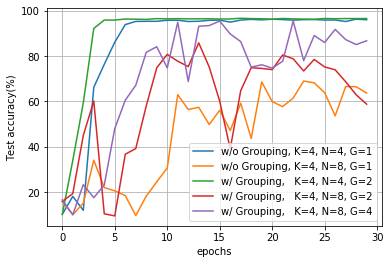

In [69]:
B_sel = 0

# plt.plot(acc_test_arr_v1[0,B_sel,0,0:30],label='N=2, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_K4_G1_v3[2,B_sel,0,0:30],label='w/o Grouping, K=4, N=4, G=1' )
plt.plot(acc_test_arr_K4_G1_v3[3,B_sel,0,0:30],label='w/o Grouping, K=4, N=8, G=1' )
# plt.plot(acc_test_arr_v1[2,B_sel,0,0:30],label='N=6, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v1[3,B_sel,0,0:30],label='N=8, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_G2_N4_v3[0,0:30],label='w/ Grouping,   K=4, N=4, G=2')
plt.plot(acc_test_arr_K4_G2_N8_v3[0,0:30],label='w/ Grouping,   K=4, N=8, G=2')
plt.plot(acc_test_arr_K4_G4_N8_v3[0,0:30],label='w/ Grouping,   K=4, N=8, G=4')
# plt.plot(acc_test_arr_G3[0,0:30],label='Grouping, N=6, G=3, B='+str(B_array[B_sel]))

# plt.plot(acc_test_arr_v1[4,B_sel,0,0:30],label='N=7, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v1[5,B_sel,0,0:30],label='N=8, B='+str(B_array[B_sel]))

# plt.plot(plot_acc_v2[2,sigma_sel,:],label='T=10')
# plt.plot(plot_acc_v2[3,sigma_sel,:],label='T=11')

# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()